# Cell type specific markers in WT Arabidopsis roots

#### Working directory should contain root atlas Seurat object, which is available on GEO under record GSE152766:

    Root_Atlas.rds (or get it by running through notebook 2, 3, 4, 5, 6, 7, 8, 9 & 10)
    
#### Working directory must contain subdirectories,supp_data

#### supp_data/ should contain the files, which are available on Github (github.com/Hsu-Che-Wei/COPILOT):

    features.tsv.gz
    Curated_Markers.csv

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [1]:
library(tidyverse)
library(Seurat)
library(RColorBrewer)
library(future)
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
# Load atlas
rc.integrated <- readRDS("./Root_Atlas.rds")

In [4]:
# Simple QC label
rc.integrated$celltype.anno <- gsub("Putative Quiescent Center", "Quiescent Center", rc.integrated$celltype.anno, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

order <- c("Quiescent Center", "Stem Cell Niche", "Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Pericycle", "Phloem", "Xylem", "Procambium", "Unknown")
palette <- c("#9400d3", "#DCD0FF", "#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#FF9900","#E6194B", "#9A6324", "#FFE119","#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))])
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]


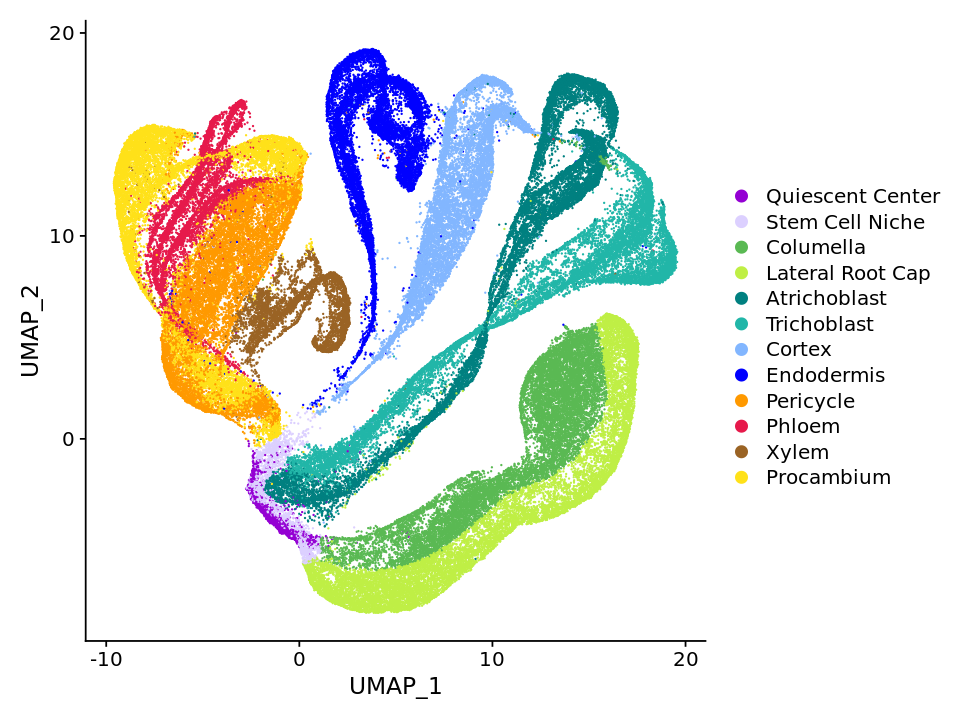

In [5]:
# Plot atlas with celltype annotation
options(repr.plot.width=8, repr.plot.height=6)
DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color)

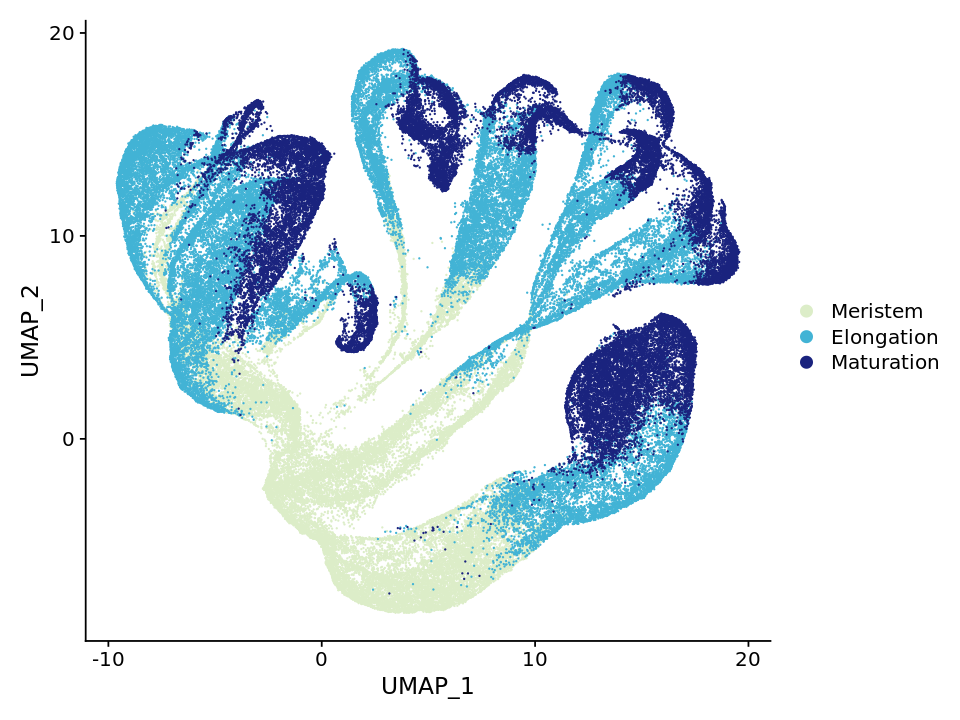

In [6]:
# Plot atlas with time zone annotation
options(repr.plot.width=8, repr.plot.height=6)
time_plt <- DimPlot(rc.integrated, 
        group.by = "time.anno", 
        order = c("Maturation","Elongation","Meristem"),
        cols = c("#DCEDC8", "#42B3D5", "#1A237E"))
time_plt

## FindMarkers for each cell type

In [7]:
# Set the identity of interest to cell type
Idents(rc.integrated) <- "celltype.anno"
# Set the expression matrix used for DE to batch-corrected and scaled one 
DefaultAssay(rc.integrated) <- "integrated"

In [8]:
# run differentially expression (DE) analysis using ROC method, select randomly 10000 cells for each cell type
Clust_Markers <- FindAllMarkers(rc.integrated,
                                logfc.threshold=log(2),
                                min.diff.pct = 0.25,
                                max.cells.per.ident = 10000,
                                only.pos=T, 
                               test.use="roc")

Calculating cluster Quiescent Center

Calculating cluster Stem Cell Niche

Calculating cluster Columella

Calculating cluster Lateral Root Cap

Calculating cluster Atrichoblast

Calculating cluster Trichoblast

Calculating cluster Cortex

Calculating cluster Endodermis

Calculating cluster Pericycle

Calculating cluster Phloem

Calculating cluster Xylem

Calculating cluster Procambium



In [9]:
# Load in gene ids and names
feature_names <- read_tsv("./supp_data/features.tsv.gz", col_names = c("gene", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


Parsed with column specification:
cols(
  gene = col_character(),
  Name = col_character(),
  Type = col_character()
)



In [10]:
# Merge the DE output with corresponding gene id and name
Clust_Markers <- left_join(Clust_Markers, feature_names)

Joining, by = "gene"



In [11]:
# For each cell type, select the top 3 genes according to AUC score
Clust_Markers %>% group_by(cluster) %>% top_n(3, myAUC)

myAUC avg_diff power pct.1 pct.2 cluster          gene      Name     
1  0.975 3.418046 0.950 0.995 0.235 Quiescent Center AT2G20490 NOP10    
2  0.969 3.320833 0.938 0.982 0.180 Quiescent Center AT2G37600 RPL36A   
3  0.967 3.141538 0.934 0.982 0.142 Quiescent Center AT4G25630 MED36A   
4  0.963 2.924185 0.926 0.996 0.266 Stem Cell Niche  AT1G27400 RPL17A   
5  0.959 3.152680 0.918 0.963 0.138 Stem Cell Niche  AT4G25630 MED36A   
6  0.959 2.965380 0.918 0.980 0.182 Stem Cell Niche  AT4G10450 RPL9D    
7  0.959 2.863416 0.918 0.991 0.248 Stem Cell Niche  AT3G45030 RPS20C   
8  0.959 2.842732 0.918 0.993 0.254 Stem Cell Niche  AT3G16080 RPL37C   
9  0.959 2.782642 0.918 0.993 0.247 Stem Cell Niche  AT5G16130 RPS7C    
10 0.954 4.991188 0.908 0.946 0.204 Columella        AT5G53460 GLT1     
11 0.949 4.788331 0.898 0.853 0.053 Columella        AT4G15530 PPDK     
12 0.940 3.515608 0.880 0.931 0.168 Columella        AT4G37870 PCKA     
13 0.940 2.513056 0.880 0.973 0.192 Lateral Root Cap AT2G41800 AT2G41800
14 0.922 4.561689 0.844 0.829 0.076 Lateral Root Cap AT4G37160 sks15    
15 0.922 4.186420 0.844 0.803 0.080 Lateral Root Cap AT1G54010 GLL23    
16 0.915 2.640102 0.830 0.878 0.164 Atrichoblast     AT1G13590 PSK1     
17 0.902 3.111698 0.804 0.859 0.186 Atrichoblast     AT3G29250 SDR4     
18 0.886 4.542298 0.772 0.822 0.259 Atrichoblast     AT5G60950 COBL5    
19 0.984 8.161201 0.968 0.956 0.077 Trichoblast      AT1G23750 AT1G23750
20 0.973 6.960778 0.946 0.960 0.135 Trichoblast      AT5G40510 AT5G40510
21 0.968 4.717539 0.936 0.955 0.180 Trichoblast      AT1G58270 ZW9      
22 0.986 5.212618 0.972 0.979 0.068 Cortex           AT1G02850 BGLU11   
23 0.976 3.734003 0.952 0.962 0.097 Cortex           AT1G12090 ELP      
24 0.966 5.897286 0.932 0.944 0.117 Cortex           AT5G65380 DTX27    
25 0.995 6.121006 0.990 0.977 0.024 Endodermis       AT2G14900 GASA7    
26 0.992 5.140404 0.984 0.972 0.033 Endodermis       AT1G05260 PER3     
27 0.985 5.456284 0.970 0.915 0.032 Endodermis       AT4G11290 PER39    
28 0.933 3.732360 0.866 0.939 0.226 Pericycle        AT1G27130 GSTU13   
29 0.933 2.125197 0.866 0.964 0.158 Pericycle        AT2G02130 PDF2.3   
30 0.931 3.108885 0.862 0.952 0.222 Pericycle        AT4G34620 RPS16-1  
31 0.982 4.813068 0.964 0.973 0.071 Phloem           AT3G43270 PME32    
32 0.973 3.254128 0.946 0.988 0.140 Phloem           AT3G21770 PER30    
33 0.970 3.633247 0.940 0.959 0.066 Phloem           AT1G07640 OBP2     
34 0.984 6.477189 0.968 0.963 0.006 Xylem            AT4G36160 ANAC076  
35 0.978 6.788948 0.956 0.960 0.014 Xylem            AT5G03170 FLA11    
36 0.973 4.338466 0.946 0.970 0.082 Xylem            AT3G51030 TRX1     
37 0.937 2.342464 0.874 0.927 0.155 Procambium       AT1G12080 AT1G12080
38 0.929 3.328809 0.858 0.897 0.146 Procambium       AT5G05690 CYP90A1  
39 0.920 2.560164 0.840 0.881 0.174 Procambium       AT2G13820 AT2G13820

In [12]:
Clust_Markers$cluster_gene <- paste(Clust_Markers$cluster, Clust_Markers$gene, sep="_")

In [13]:
# store all results 

All_clust_markers <- Clust_Markers

# subset based on AUC 0.75

Clust_Markers <- filter(Clust_Markers, myAUC>=0.75)

In [14]:
# Calculate the frequency of genes being detected as marker
(times_per_gene <- Clust_Markers %>%
ungroup() %>%
group_by(gene) %>%
tally())

gene      n
1    AT1G01010 1
2    AT1G01070 1
3    AT1G01100 2
4    AT1G01170 1
5    AT1G01240 1
6    AT1G01360 1
7    AT1G01380 1
8    AT1G01570 1
9    AT1G01580 1
10   AT1G01750 1
11   AT1G01900 1
12   AT1G01940 1
13   AT1G02160 1
14   AT1G02205 1
15   AT1G02340 1
16   AT1G02380 1
17   AT1G02460 1
18   AT1G02500 1
19   AT1G02640 1
20   AT1G02690 2
21   AT1G02770 1
22   AT1G02780 2
23   AT1G02810 1
24   AT1G02840 1
25   AT1G02850 1
26   AT1G02870 2
27   AT1G02880 1
28   AT1G02900 1
29   AT1G02920 1
30   AT1G03010 1
⋮    ⋮         ⋮
3952 AT5G66120 1
3953 AT5G66170 1
3954 AT5G66230 1
3955 AT5G66300 1
3956 AT5G66320 1
3957 AT5G66440 1
3958 AT5G66460 1
3959 AT5G66510 1
3960 AT5G66530 2
3961 AT5G66540 1
3962 AT5G66580 1
3963 AT5G66600 1
3964 AT5G66607 1
3965 AT5G66680 1
3966 AT5G66690 2
3967 AT5G66770 2
3968 AT5G66800 2
3969 AT5G66860 2
3970 AT5G66870 1
3971 AT5G66920 2
3972 AT5G67150 1
3973 AT5G67180 1
3974 AT5G67200 1
3975 AT5G67220 2
3976 AT5G67230 1
3977 AT5G67240 1
3978 AT5G67260 1
3979 AT5G67470 1
3980 AT5G67510 2
3981 AT5G67620 1

In [15]:
Clust_Markers <- left_join(Clust_Markers, times_per_gene)

Joining, by = "gene"



In [16]:
summary(Clust_Markers$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.571   2.000   4.000 

In [17]:
# Load libraries for plotting
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(ggplot2)


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


circlize version 0.4.8
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: http://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualiza

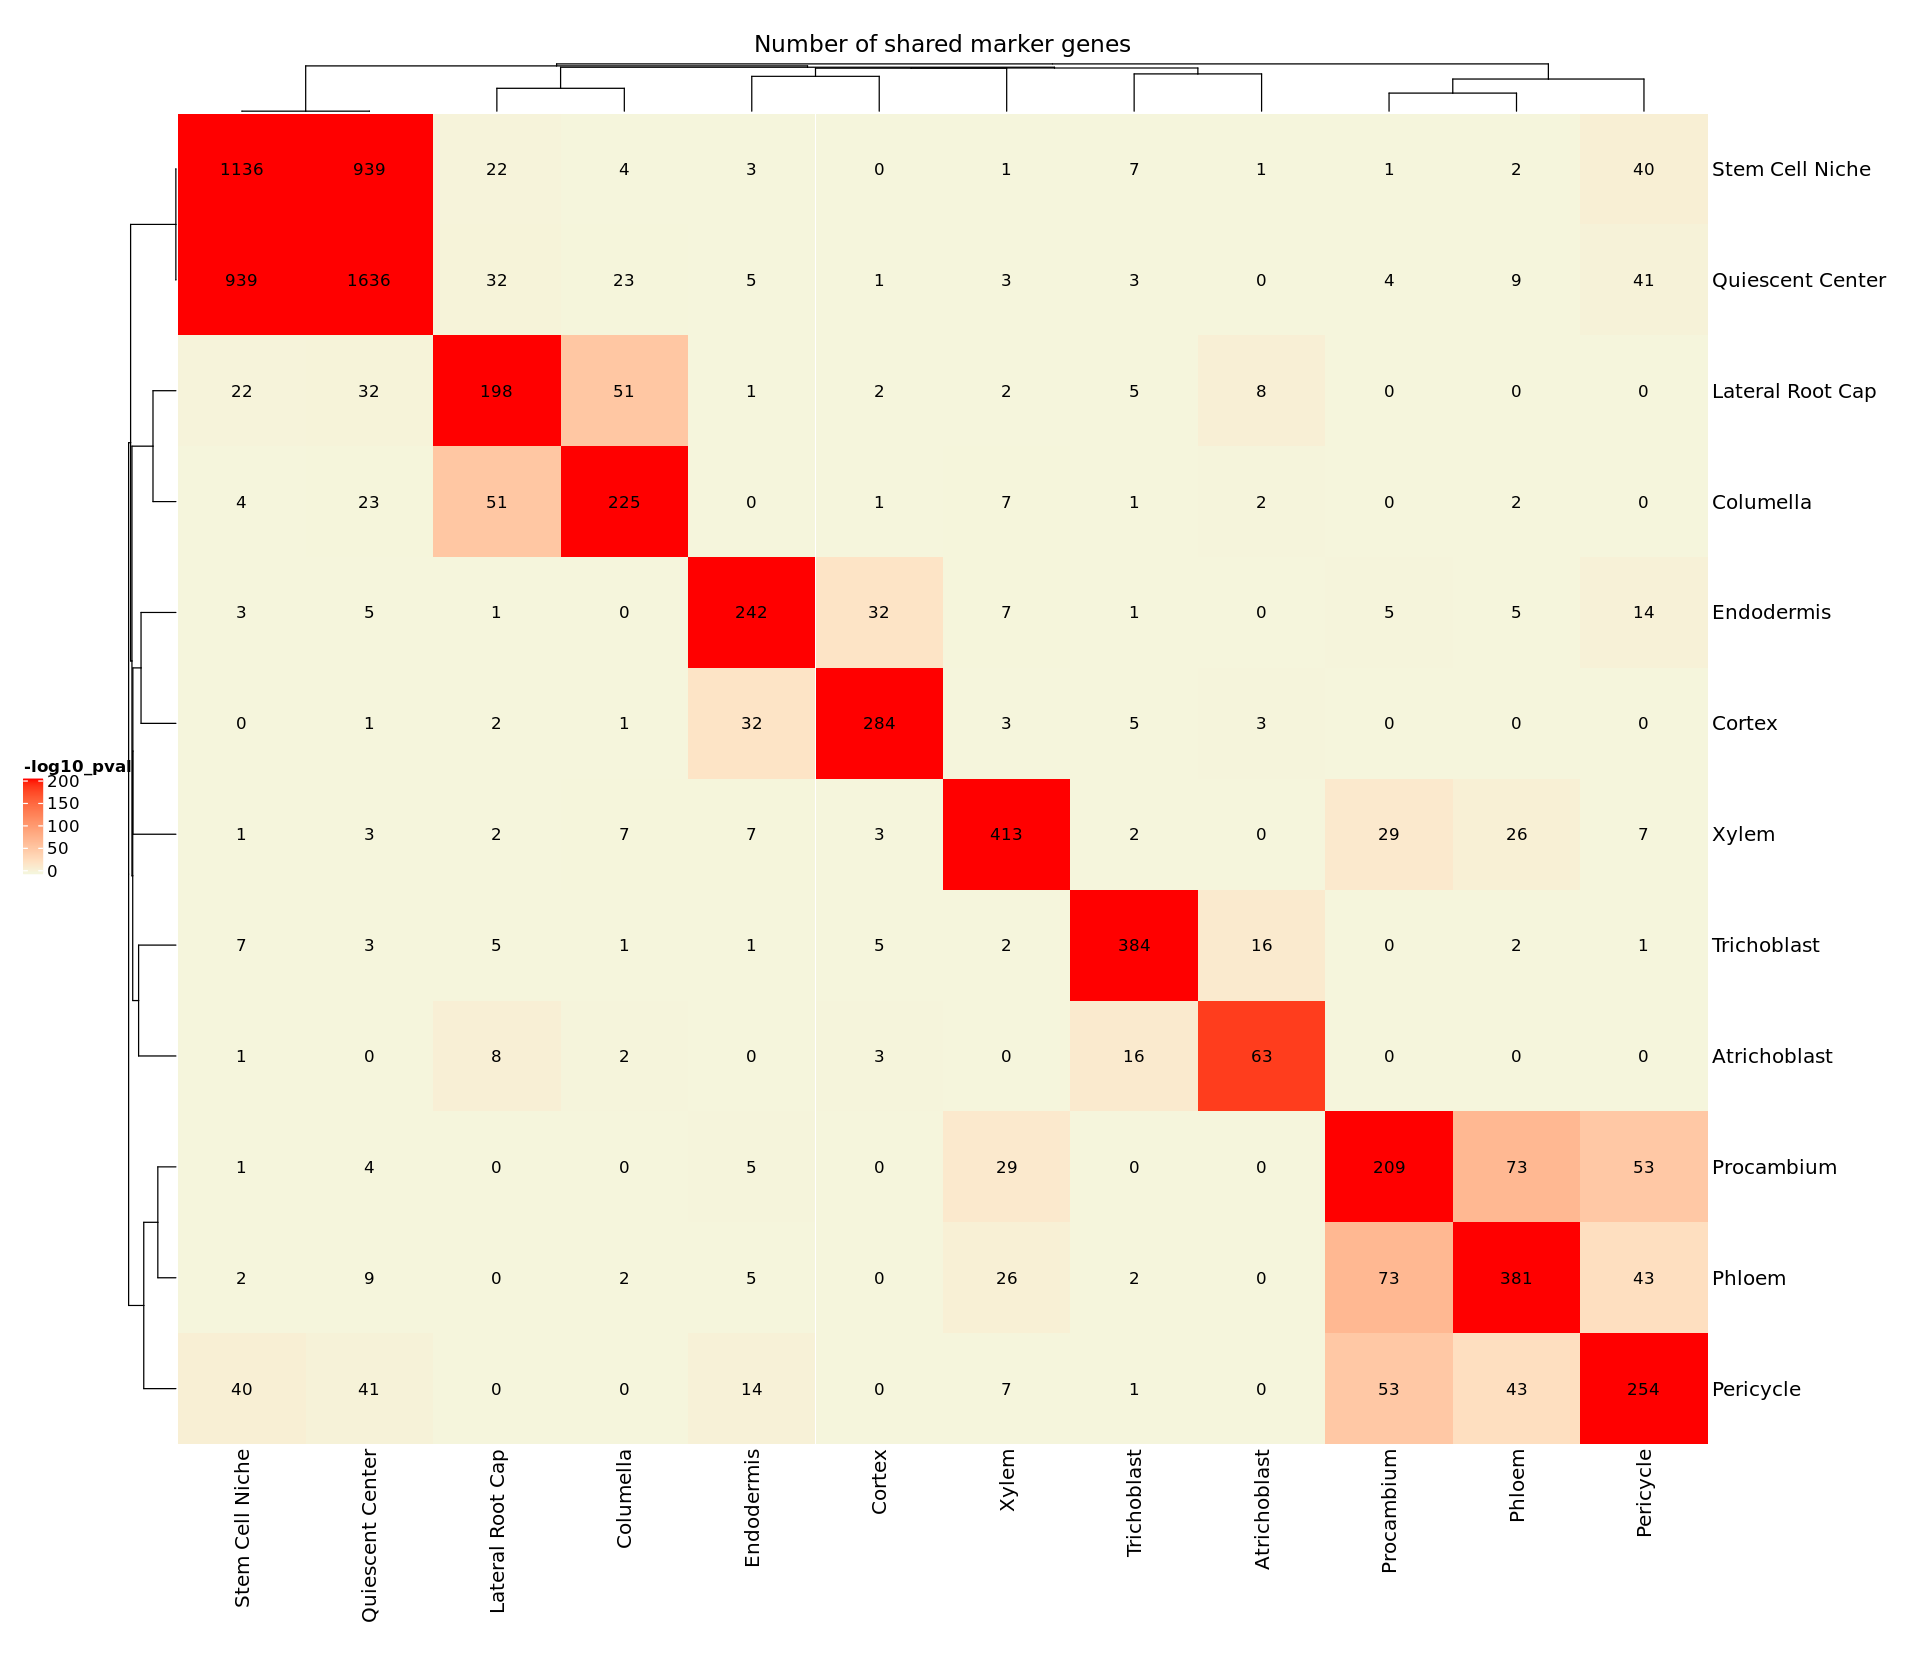

In [18]:
options(repr.plot.width = 16, repr.plot.height = 14)


markers_sel <- select(Clust_Markers, gene, cluster)

markers_list <- split(markers_sel, f=markers_sel$cluster)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))
 
## GeneOverlap 

# number of integrated features

genome_size <- 17513L

#compare all lists
gom.self <- newGOM(markers_list, markers_list, genome.size=genome_size)


int <- getNestedList(gom.self, "intersection")
int_matrix <- getMatrix(gom.self, "intersection")
p.val <- getMatrix(gom.self, "pval")
JC <- getMatrix(gom.self, "Jaccard")

# log of p.val for intersection
p.val_log <- -log10(p.val + 1e-200)


olap <- Heatmap(p.val_log, 
                name = "-log10_pval", 
                col = colorRamp2(c(0, 200), 
                                 c("beige", "red")), 
                column_title = "Number of shared marker genes", 
                cluster_rows = T,
                cluster_columns = T, 
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                clustering_distance_rows = "pearson",
                clustering_distance_columns = "pearson", 
                show_column_dend = TRUE, cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))
}) 
                        
                        # padding - bottom, left, top, right
draw(olap, padding = unit(c(15, 5, 5, 10), "mm"), heatmap_legend_side = "left")

In [19]:
# Load GO terms for Arabidopsis thaliana
cluster_GO <- gost(markers_list, organism = "athaliana", correction_method = "fdr", significant = F, multi_query = F)

cluster_GO_df <- cluster_GO[[1]]

cluster_GO_sig <- filter(cluster_GO_df, p_value<=0.01)

# top  terms for each cluster

cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(query) %>%
  top_n(5, wt = -p_value) %>%
  arrange(desc(p_value)) -> top_GO

GO_n <- cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(term_id) %>%
  tally() %>%
  arrange(desc(n))


GO_n <- dplyr::rename(GO_n, "n_clusters"=n)

cluster_GO_sig_n <- left_join(cluster_GO_sig, GO_n)

# get all terms for the top ones so that all clusters have values

top_GO_all <- filter(cluster_GO_df, term_id %in% top_GO$term_id)


#spread and plot


top_GO_sel <- select(top_GO_all, query, p_value, term_id, term_name)

spread_GO <- spread(top_GO_sel, key = query, p_value)

spread_GO[is.na(spread_GO)] <- 1

spread_GO_m <- as.matrix(-log10(spread_GO[3:ncol(spread_GO)]))
rownames(spread_GO_m) <- spread_GO$term_name



Joining, by = "term_id"



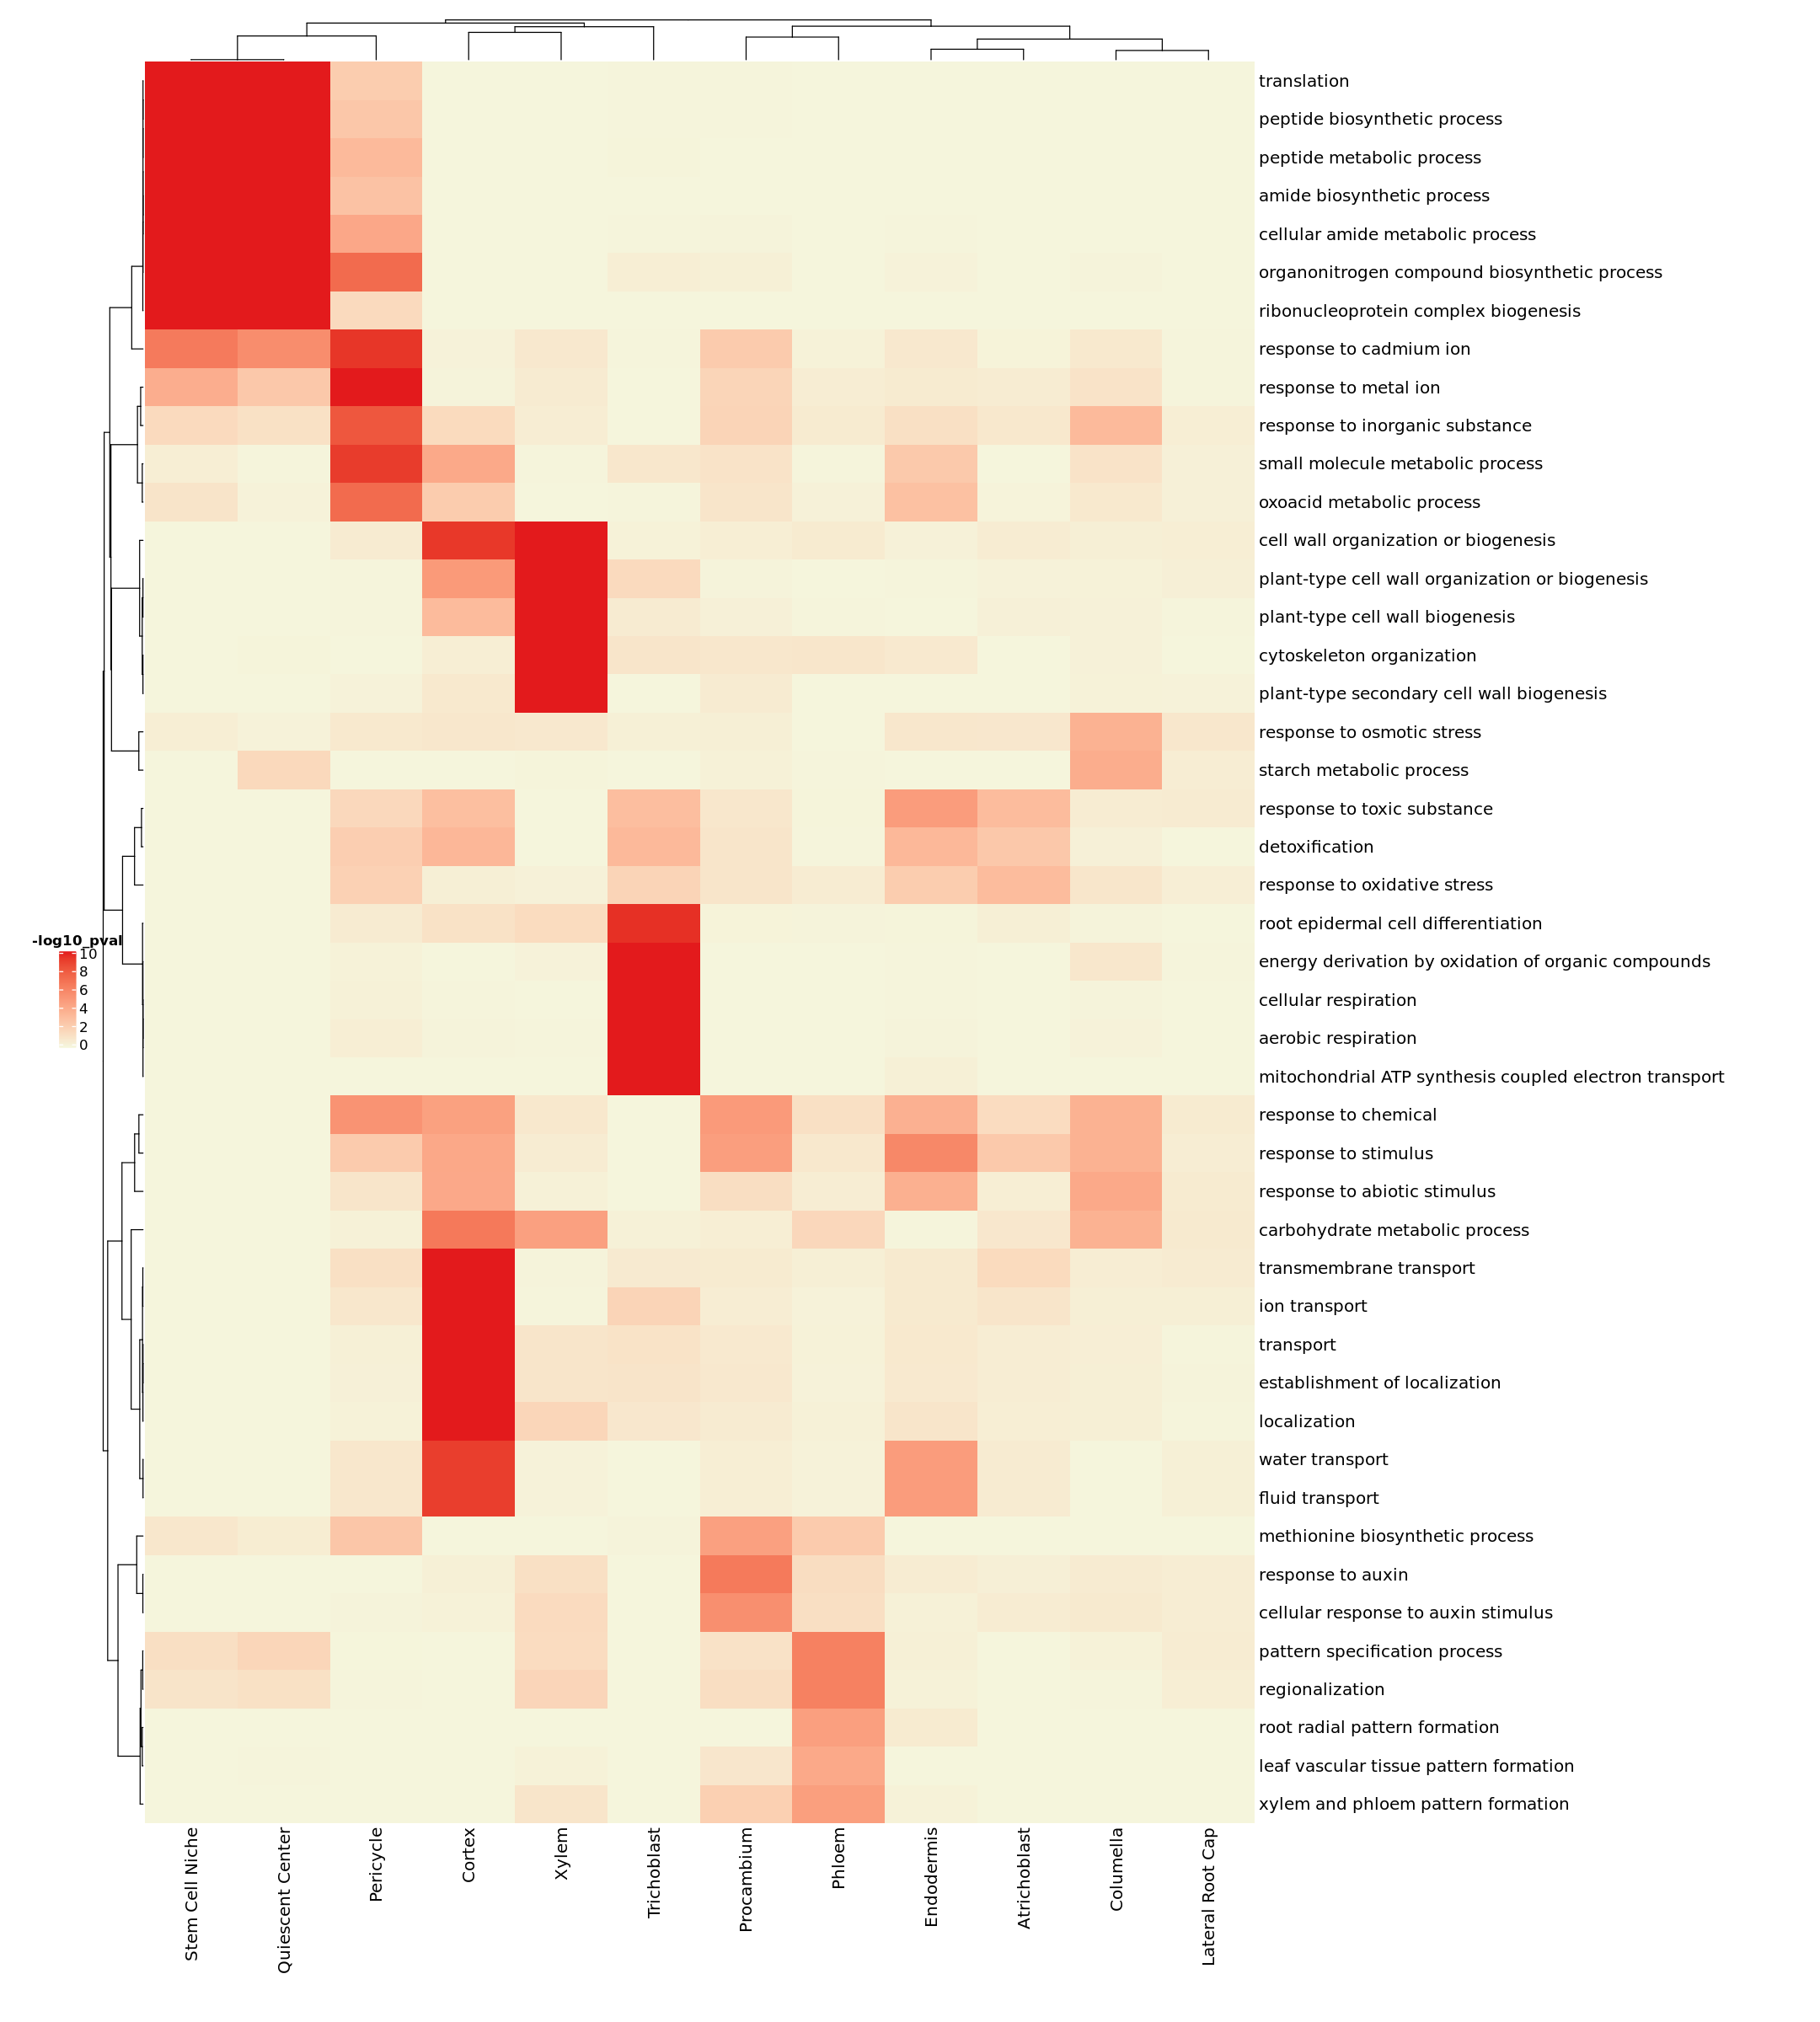

In [20]:
options(repr.plot.width = 18, repr.plot.height = 20)

GO_hm <- Heatmap(spread_GO_m, 
                 name = "-log10_pval", 
                 heatmap_legend_param = list(title_position="topcenter", color_bar = "continuous"), 
                 col = colorRamp2(c(0, 10), 
                                  c("beige", "#e31a1c")), 
                 cluster_rows = T,
                 cluster_columns = T, 
                 use_raster= FALSE, 
                 show_column_names = TRUE, 
                 show_row_names = TRUE, 
                 show_row_dend = TRUE, 
                 show_column_dend = TRUE, 
                 clustering_distance_rows = "pearson",
                 clustering_distance_columns = "pearson", 
                 row_names_gp = gpar(fontsize = 12)) 


# padding - bottom, left, top, right
draw(GO_hm, padding = unit(c(15, 15, 5, 80), "mm"), heatmap_legend_side = "left")

In [21]:
# Load the known markers
(used.markers <- read_csv("./supp_data/Curated_Markers.csv"))

Parsed with column specification:
cols(
  Locus = col_character(),
  Gene = col_character(),
  Celltype = col_character(),
  Source = col_character()
)



Locus     Gene      Celltype         Source        
1  AT4G00490 BAM2      Columella        Plant Phys    
2  AT1G62510 AT1G62510 Cortex           Plant Phys    
3  AT5G07990 CYP75B1   Cortex           Plant Phys    
4  AT5G55250 IAMT1     Cortex           Plant Phys    
5  AT1G61590 AT1G61590 Endodermis       Plant Phys    
6  AT4G02090 AT4G02090 Endodermis       Plant Phys    
7  AT3G11550 CASP2     Endodermis       Plant Phys    
8  AT2G27370 CASP3     Endodermis       Plant Phys    
9  AT5G06200 CASP4     Endodermis       Plant Phys    
10 AT5G57620 MYB36     Endodermis       Plant Phys    
11 AT5G42180 PER64     Endodermis       Plant Phys    
12 AT1G33090 AT1G33090 Trichoblast      Plant Phys    
13 AT3G09330 AT3G09330 Trichoblast      Plant Phys    
14 AT5G49270 COBL9     Trichoblast      Plant Phys    
15 AT1G48930 GH9C1     Trichoblast      Plant Phys    
16 AT1G69240 MES15     Trichoblast      Plant Phys    
17 AT1G45545 WEL2      Trichoblast      Plant Phys    
18 AT4G37160 sks15     Lateral Root Cap Plant Phys    
19 AT1G79840 GL2       Atrichoblast     Plant Phys    
20 AT2G37260 WRKY44    Atrichoblast     Plant Phys    
21 AT1G65310 XTH17     Atrichoblast     Plant Phys    
22 AT1G79430 APL       Phloem           Plant Phys    
23 AT5G62940 DOF5.6    Phloem           Plant Phys    
24 AT2G37090 IRX9      Xylem            Plant Phys    
25 AT5G12870 MYB46     Xylem            Plant Phys    
26 AT3G09070 OPS       Procambium       Nagawa et al. 
27 AT5G43810 AGO10     Procambium       Nagawa et al. 
28 AT5G26930 GATA23    Pericycle        Beekman et al.
29 AT3G26120 TEL1      Quiescent Center Denyer et al. 
30 AT3G43270 PME32     Phloem           Denyer et al. 
31 AT1G68470 AT1G68470 Atrichoblast     escoring      
32 AT1G55440 AT1G55440 Trichoblast      escoring      
33 AT1G11330 RDA2      Pericycle        escoring      
34 AT1G26790 CDF6      Phloem           escoring      
35 AT3G05180 AT3G05180 Xylem            escoring      
36 AT3G55930 AT3G55930 Lateral Root Cap escoring      
37 AT5G36880 ACS       Lateral Root Cap escoring      
38 AT1G23210 GH9B6     Columella        escoring      
39 AT5G57640 AT5G57640 Columella        escoring      
40 AT3G60650 AT3G60650 Columella        escoring      
41 AT1G13620 RGF2      Columella        escoring      
42 AT1G17400 DRO3      Columella        escoring      
43 AT1G55200 AT1G55200 Quiescent Center escoring      
44 AT5G45210 AT5G45210 Endodermis       Clark et al.

In [22]:
used.markers$cluster_gene <- paste(used.markers$Celltype, used.markers$Locus, sep="_")

In [23]:
# Combine DE output to see whether the known markers are captured
Clust_Markers <- mutate(Clust_Markers, pct.diff=pct.1-pct.2)

Clust_Markers <- arrange(Clust_Markers, desc(pct.diff)) %>%
group_by(cluster) %>%
mutate(pct.diff_rank=dplyr::row_number()) %>%
arrange(desc(avg_diff)) %>%
mutate(avg_diff_rank=dplyr::row_number()) %>%
arrange(desc(myAUC)) %>%
mutate(myAUC_rank=dplyr::row_number()) %>%
mutate(combined_rank_raw=(pct.diff_rank + avg_diff_rank + myAUC_rank)/3) %>%
arrange(combined_rank_raw) %>%
mutate(combined_rank=dplyr::row_number()) %>%
select(-combined_rank_raw) %>%
mutate(known_marker=cluster_gene %in% used.markers$cluster_gene) %>%
arrange(combined_rank)
Clust_Markers

myAUC avg_diff  power pct.1 pct.2 cluster          gene      Name     
1    0.984 8.161201  0.968 0.956 0.077 Trichoblast      AT1G23750 AT1G23750
2    0.954 4.991188  0.908 0.946 0.204 Columella        AT5G53460 GLT1     
3    0.922 4.561689  0.844 0.829 0.076 Lateral Root Cap AT4G37160 sks15    
4    0.995 6.121006  0.990 0.977 0.024 Endodermis       AT2G14900 GASA7    
5    0.986 5.212618  0.972 0.979 0.068 Cortex           AT1G02850 BGLU11   
6    0.877 4.664794  0.754 0.767 0.076 Atrichoblast     AT5G44585 AT5G44585
7    0.933 3.732360  0.866 0.939 0.226 Pericycle        AT1G27130 GSTU13   
8    0.929 3.328809  0.858 0.897 0.146 Procambium       AT5G05690 CYP90A1  
9    0.978 6.788948  0.956 0.960 0.014 Xylem            AT5G03170 FLA11    
10   0.982 4.813068  0.964 0.973 0.071 Phloem           AT3G43270 PME32    
11   0.951 3.960180  0.902 0.952 0.140 Quiescent Center AT4G16141 AT4G16141
12   0.955 3.394651  0.910 0.945 0.139 Stem Cell Niche  AT3G15357 AT3G15357
13   0.949 4.788331  0.898 0.853 0.053 Columella        AT4G15530 PPDK     
14   0.981 6.761283  0.962 0.935 0.018 Endodermis       AT5G57620 MYB36    
15   0.966 5.897286  0.932 0.944 0.117 Cortex           AT5G65380 DTX27    
16   0.922 4.186420  0.844 0.803 0.080 Lateral Root Cap AT1G54010 GLL23    
17   0.973 6.960778  0.946 0.960 0.135 Trichoblast      AT5G40510 AT5G40510
18   0.861 4.037905  0.722 0.789 0.120 Atrichoblast     AT2G37130 PER21    
19   0.915 3.643172  0.830 0.881 0.162 Pericycle        AT1G16350 AT1G16350
20   0.957 5.303659  0.914 0.930 0.063 Phloem           AT1G78580 TPS1     
21   0.879 4.705379  0.758 0.745 0.069 Procambium       AT2G40480 AT2G40480
22   0.984 6.477189  0.968 0.963 0.006 Xylem            AT4G36160 ANAC076  
23   0.945 4.036993  0.890 0.924 0.105 Quiescent Center AT2G12646 AT2G12646
24   0.945 3.657503  0.890 0.956 0.182 Stem Cell Niche  AT2G42740 RPL11A   
25   0.974 6.719433  0.948 0.871 0.012 Endodermis       AT2G22000 PEP6     
26   0.903 4.563464  0.806 0.776 0.057 Columella        AT1G22880 CEL5     
27   0.944 8.003785  0.888 0.837 0.115 Trichoblast      AT2G01540 CAR10    
28   0.902 3.111698  0.804 0.859 0.186 Atrichoblast     AT3G29250 SDR4     
29   0.916 3.242063  0.832 0.860 0.189 Lateral Root Cap AT3G16410 NSP4     
30   0.931 3.108885  0.862 0.952 0.222 Pericycle        AT4G34620 RPS16-1  
⋮    ⋮     ⋮         ⋮     ⋮     ⋮     ⋮                ⋮         ⋮        
5396 0.758 0.8817055 0.516 0.676 0.213 Quiescent Center AT1G11720 ATSS3    
5397 0.764 0.9034369 0.528 0.735 0.311 Quiescent Center AT2G47640 AT2G47640
5398 0.753 1.1408003 0.506 0.697 0.255 Quiescent Center AT4G09140 MLH1     
5399 0.752 0.9666352 0.504 0.710 0.235 Quiescent Center AT3G18240 AT3G18240
5400 0.759 0.8921020 0.518 0.701 0.250 Quiescent Center AT2G44270 NCS6     
5401 0.768 0.7246809 0.536 0.792 0.375 Quiescent Center AT5G56010 HSP90-3  
5402 0.763 0.8777123 0.526 0.707 0.279 Quiescent Center AT5G06060 AT5G06060
5403 0.755 0.9218126 0.510 0.721 0.257 Quiescent Center AT1G19520 NFD5     
5404 0.754 0.8299999 0.508 0.733 0.258 Quiescent Center AT3G61530 KPHMT2   
5405 0.750 1.1706780 0.500 0.700 0.266 Quiescent Center AT4G15640 AT4G15640
5406 0.750 1.0575788 0.500 0.701 0.243 Quiescent Center AT2G44040 DAPB1    
5407 0.755 1.0463468 0.510 0.661 0.234 Quiescent Center AT3G50340 AT3G50340
5408 0.762 0.7585482 0.524 0.702 0.258 Quiescent Center AT4G29430 RPS15AE  
5409 0.756 1.0212937 0.512 0.670 0.256 Quiescent Center AT4G37660 AT4G37660
5410 0.762 0.8152083 0.524 0.776 0.350 Quiescent Center AT4G02450 P23-1    
5411 0.756 0.8898193 0.512 0.700 0.249 Quiescent Center AT4G26670 TIM22-2  
5412 0.753 1.1239899 0.506 0.526 0.198 Quiescent Center AT1G07820 AT1G07820
5413 0.753 0.8308445 0.506 0.588 0.117 Quiescent Center AT5G60250 AT5G60250
5414 0.762 0.8121603 0.524 0.756 0.344 Quiescent Center AT5G49510 PFD3     
5415 0.752 1.0097901 0.504 0.693 0.251 Quiescent Center AT1G19080 TTN10    
5416 0.751 0.9115209 0.502 0.709 0.248 Quiescent Cent

In [24]:
# Store the data
write.csv(Clust_Markers, "./supp_data/Atlas_celltype_markers_ROC.csv", row.names=F)

In [25]:
# Plotting the expression pattern of known markers 
used.markers.to.plt <- used.markers

used.markers.to.plt$cluster <- used.markers.to.plt$Celltype

used.markers.to.plt$cluster <- factor(used.markers.to.plt$cluster, levels= c("Quiescent Center", "Stem Cell Niche", "Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Pericycle", "Phloem", "Xylem", "Procambium"))

used.markers.to.plt <- arrange(used.markers.to.plt, cluster)

used.markers.to.plt

ct_to_plt_Names <- rev(used.markers.to.plt$Gene)
ct_to_plt_genes <- rev(used.markers.to.plt$Locus)
breaks <- rev(ct_to_plt_genes)
labels <- rev(ct_to_plt_Names)

Locus     Gene      Celltype         Source        
1  AT3G26120 TEL1      Quiescent Center Denyer et al. 
2  AT1G55200 AT1G55200 Quiescent Center escoring      
3  AT4G00490 BAM2      Columella        Plant Phys    
4  AT1G23210 GH9B6     Columella        escoring      
5  AT5G57640 AT5G57640 Columella        escoring      
6  AT3G60650 AT3G60650 Columella        escoring      
7  AT1G13620 RGF2      Columella        escoring      
8  AT1G17400 DRO3      Columella        escoring      
9  AT4G37160 sks15     Lateral Root Cap Plant Phys    
10 AT3G55930 AT3G55930 Lateral Root Cap escoring      
11 AT5G36880 ACS       Lateral Root Cap escoring      
12 AT1G79840 GL2       Atrichoblast     Plant Phys    
13 AT2G37260 WRKY44    Atrichoblast     Plant Phys    
14 AT1G65310 XTH17     Atrichoblast     Plant Phys    
15 AT1G68470 AT1G68470 Atrichoblast     escoring      
16 AT1G33090 AT1G33090 Trichoblast      Plant Phys    
17 AT3G09330 AT3G09330 Trichoblast      Plant Phys    
18 AT5G49270 COBL9     Trichoblast      Plant Phys    
19 AT1G48930 GH9C1     Trichoblast      Plant Phys    
20 AT1G69240 MES15     Trichoblast      Plant Phys    
21 AT1G45545 WEL2      Trichoblast      Plant Phys    
22 AT1G55440 AT1G55440 Trichoblast      escoring      
23 AT1G62510 AT1G62510 Cortex           Plant Phys    
24 AT5G07990 CYP75B1   Cortex           Plant Phys    
25 AT5G55250 IAMT1     Cortex           Plant Phys    
26 AT1G61590 AT1G61590 Endodermis       Plant Phys    
27 AT4G02090 AT4G02090 Endodermis       Plant Phys    
28 AT3G11550 CASP2     Endodermis       Plant Phys    
29 AT2G27370 CASP3     Endodermis       Plant Phys    
30 AT5G06200 CASP4     Endodermis       Plant Phys    
31 AT5G57620 MYB36     Endodermis       Plant Phys    
32 AT5G42180 PER64     Endodermis       Plant Phys    
33 AT5G45210 AT5G45210 Endodermis       Clark et al.  
34 AT5G26930 GATA23    Pericycle        Beekman et al.
35 AT1G11330 RDA2      Pericycle        escoring      
36 AT1G79430 APL       Phloem           Plant Phys    
37 AT5G62940 DOF5.6    Phloem           Plant Phys    
38 AT3G43270 PME32     Phloem           Denyer et al. 
39 AT1G26790 CDF6      Phloem           escoring      
40 AT2G37090 IRX9      Xylem            Plant Phys    
41 AT5G12870 MYB46     Xylem            Plant Phys    
42 AT3G05180 AT3G05180 Xylem            escoring      
43 AT3G09070 OPS       Procambium       Nagawa et al. 
44 AT5G43810 AGO10     Procambium       Nagawa et al. 
   cluster_gene               cluster         
1  Quiescent Center_AT3G26120 Quiescent Center
2  Quiescent Center_AT1G55200 Quiescent Center
3  Columella_AT4G00490        Columella       
4  Columella_AT1G23210        Columella       
5  Columella_AT5G57640        Columella       
6  Columella_AT3G60650        Columella       
7  Columella_AT1G13620        Columella       
8  Columella_AT1G17400        Columella       
9  Lateral Root Cap_AT4G37160 Lateral Root Cap
10 Lateral Root Cap_AT3G55930 Lateral Root Cap
11 Lateral Root Cap_AT5G36880 Lateral Root Cap
12 Atrichoblast_AT1G79840     Atrichoblast    
13 Atrichoblast_AT2G37260     Atrichoblast    
14 Atrichoblast_AT1G65310     Atrichoblast    
15 Atrichoblast_AT1G68470     Atrichoblast    
16 Trichoblast_AT1G33090      Trichoblast     
17 Trichoblast_AT3G09330      Trichoblast     
18 Trichoblast_AT5G49270      Trichoblast     
19 Trichoblast_AT1G48930      Trichoblast     
20 Trichoblast_AT1G69240      Trichoblast     
21 Trichoblast_AT1G45545      Trichoblast     
22 Trichoblast_AT1G55440      Trichoblast     
23 Cortex_AT1G62510           Cortex          
24 Cortex_AT5G07990           Cortex          
25 Cortex_AT5G55250           Cortex          
26 Endodermis_AT1G61590       Endodermis      
27 Endodermis_AT4G02090       Endodermis      
28 Endodermis_AT3G11550       Endodermis      
29 Endodermis_AT2G27370       Endodermis      
30 Endodermis_AT5G06200       Endodermis      
31 Endodermis_AT5G57620       Endodermis      
32 Endodermis_AT5G42180 

In [26]:

rc.integrated$celltype.anno <- fct_rev(rc.integrated$celltype.anno)

Idents(rc.integrated) <- "celltype.anno"

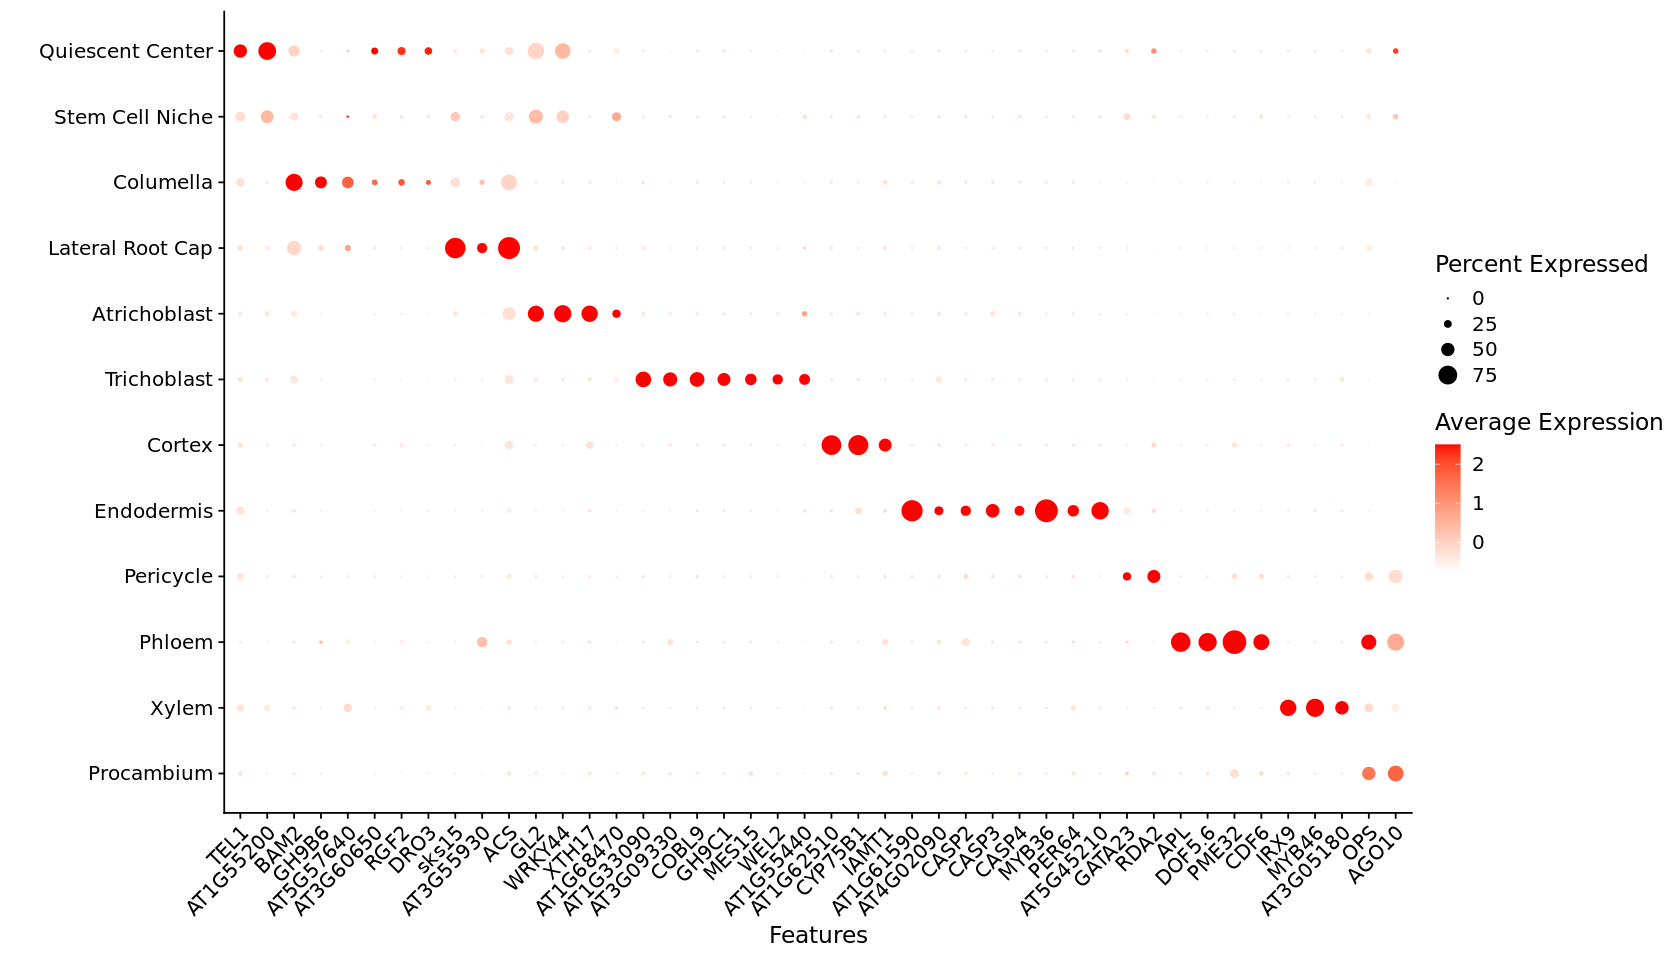

In [27]:
options(repr.plot.width=14, repr.plot.height=8)
dot <- DotPlot(object = rc.integrated, features = ct_to_plt_genes, cols = c("white", "red")) + RotatedAxis() + ylab("") + 
scale_x_discrete(breaks=breaks, labels=labels)
dot

In [28]:
# top genes to plot

novel_markers <- Clust_Markers %>%
group_by(cluster) %>%
top_n(2, -combined_rank)

novel_markers$cluster <- factor(novel_markers$cluster, levels= c("Quiescent Center", "Stem Cell Niche", "Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Pericycle", "Phloem", "Xylem", "Procambium"))

novel_markers <- arrange(novel_markers, cluster)

novel_markers

novel_markers_sel <- select(novel_markers, cluster, gene, Name)

ct_to_plt_Names <- rev(novel_markers_sel$Name)
ct_to_plt_genes <- rev(novel_markers_sel$gene)

myAUC avg_diff power pct.1 pct.2 cluster          gene      Name     
1  0.951 3.960180 0.902 0.952 0.140 Quiescent Center AT4G16141 AT4G16141
2  0.945 4.036993 0.890 0.924 0.105 Quiescent Center AT2G12646 AT2G12646
3  0.955 3.394651 0.910 0.945 0.139 Stem Cell Niche  AT3G15357 AT3G15357
4  0.945 3.657503 0.890 0.956 0.182 Stem Cell Niche  AT2G42740 RPL11A   
5  0.954 4.991188 0.908 0.946 0.204 Columella        AT5G53460 GLT1     
6  0.949 4.788331 0.898 0.853 0.053 Columella        AT4G15530 PPDK     
7  0.922 4.561689 0.844 0.829 0.076 Lateral Root Cap AT4G37160 sks15    
8  0.922 4.186420 0.844 0.803 0.080 Lateral Root Cap AT1G54010 GLL23    
9  0.877 4.664794 0.754 0.767 0.076 Atrichoblast     AT5G44585 AT5G44585
10 0.861 4.037905 0.722 0.789 0.120 Atrichoblast     AT2G37130 PER21    
11 0.984 8.161201 0.968 0.956 0.077 Trichoblast      AT1G23750 AT1G23750
12 0.973 6.960778 0.946 0.960 0.135 Trichoblast      AT5G40510 AT5G40510
13 0.986 5.212618 0.972 0.979 0.068 Cortex           AT1G02850 BGLU11   
14 0.966 5.897286 0.932 0.944 0.117 Cortex           AT5G65380 DTX27    
15 0.995 6.121006 0.990 0.977 0.024 Endodermis       AT2G14900 GASA7    
16 0.981 6.761283 0.962 0.935 0.018 Endodermis       AT5G57620 MYB36    
17 0.933 3.732360 0.866 0.939 0.226 Pericycle        AT1G27130 GSTU13   
18 0.915 3.643172 0.830 0.881 0.162 Pericycle        AT1G16350 AT1G16350
19 0.982 4.813068 0.964 0.973 0.071 Phloem           AT3G43270 PME32    
20 0.957 5.303659 0.914 0.930 0.063 Phloem           AT1G78580 TPS1     
21 0.978 6.788948 0.956 0.960 0.014 Xylem            AT5G03170 FLA11    
22 0.984 6.477189 0.968 0.963 0.006 Xylem            AT4G36160 ANAC076  
23 0.929 3.328809 0.858 0.897 0.146 Procambium       AT5G05690 CYP90A1  
24 0.879 4.705379 0.758 0.745 0.069 Procambium       AT2G40480 AT2G40480
   cluster_gene               n pct.diff pct.diff_rank avg_diff_rank myAUC_rank
1  Quiescent Center_AT4G16141 2 0.812    10            13            22        
2  Quiescent Center_AT2G12646 2 0.819     7            12            42        
3  Stem Cell Niche_AT3G15357  2 0.806     2            50            13        
4  Stem Cell Niche_AT2G42740  2 0.774    10             6            60        
5  Columella_AT5G53460        1 0.742     3             1             1        
6  Columella_AT4G15530        1 0.800     1             2             2        
7  Lateral Root Cap_AT4G37160 1 0.753     2             1             2        
8  Lateral Root Cap_AT1G54010 1 0.723     3             3             3        
9  Atrichoblast_AT5G44585     1 0.691     2             5             4        
10 Atrichoblast_AT2G37130     1 0.669     5             8             7        
11 Trichoblast_AT1G23750      1 0.879     1             1             1        
12 Trichoblast_AT5G40510      1 0.825     2             7             2        
13 Cortex_AT1G02850           1 0.911     1             6             1        
14 Cortex_AT5G65380           1 0.827     4             1             3        
15 Endodermis_AT2G14900       1 0.953     1             6             1        
16 Endodermis_AT5G57620       1 0.917     3             1             4        
17 Pericycle_AT1G27130        1 0.713     9            10             1        
18 Pericycle_AT1G16350        1 0.719     7            11             6        
19 Phloem_AT3G43270           1 0.902     1            25             1        
20 Phloem_AT1G78580           1 0.867     3            16             9        
21 Xylem_AT5G03170            1 0.946     2            22             2        
22 Xylem_AT4G36160            1 0.957     1            39             1        
23 Procambium_AT5G05690       1 0.751     2            21             2        
24 Procambium_AT2G40480       1 0.676    11             2            16        
   combined_rank known_marker
1  1             FALSE       
2  2             FALSE       
3  1             FALSE       
4  2             FALSE       
5  1             FALSE      

In [29]:
(breaks <- rev(ct_to_plt_genes))

[1] "AT4G16141" "AT2G12646" "AT3G15357" "AT2G42740" "AT5G53460" "AT4G15530"
 [7] "AT4G37160" "AT1G54010" "AT5G44585" "AT2G37130" "AT1G23750" "AT5G40510"
[13] "AT1G02850" "AT5G65380" "AT2G14900" "AT5G57620" "AT1G27130" "AT1G16350"
[19] "AT3G43270" "AT1G78580" "AT5G03170" "AT4G36160" "AT5G05690" "AT2G40480"

In [30]:
(labels <- rev(ct_to_plt_Names))

[1] "AT4G16141" "AT2G12646" "AT3G15357" "RPL11A"    "GLT1"      "PPDK"     
 [7] "sks15"     "GLL23"     "AT5G44585" "PER21"     "AT1G23750" "AT5G40510"
[13] "BGLU11"    "DTX27"     "GASA7"     "MYB36"     "GSTU13"    "AT1G16350"
[19] "PME32"     "TPS1"      "FLA11"     "ANAC076"   "CYP90A1"   "AT2G40480"

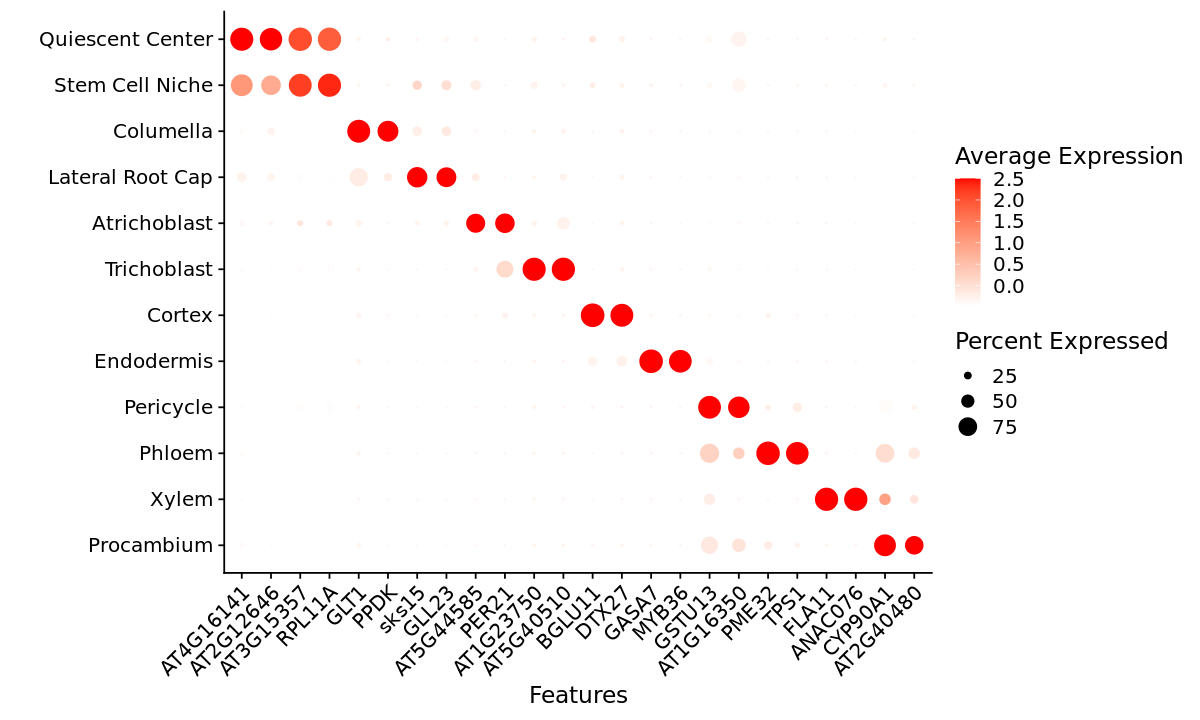

In [31]:
options(repr.plot.width=10, repr.plot.height=6)
dot <- DotPlot(object = rc.integrated, features = ct_to_plt_genes, cols = c("white", "red")) + RotatedAxis() + ylab("") + 
scale_x_discrete(breaks=breaks, labels=labels)
dot

# Specific genes by cell type and developmental stage

In [32]:
table(rc.integrated$time.celltype.anno)


           Elongation-Atrichoblast               Elongation-Columella 
                              5223                               2405 
                 Elongation-Cortex              Elongation-Endodermis 
                              5698                               4801 
       Elongation-Lateral Root Cap               Elongation-Pericycle 
                              4273                               6265 
                 Elongation-Phloem              Elongation-Procambium 
                              4078                               6275 
            Elongation-Trichoblast                   Elongation-Xylem 
                              4598                               2752 
           Maturation-Atrichoblast               Maturation-Columella 
                              3661                               6834 
                 Maturation-Cortex              Maturation-Endodermis 
                              2822                               4273 
     

In [33]:
### combination of time and cell type anno

rc.integrated$cell_time_final <- rc.integrated$time.celltype.anno

In [34]:
rc.integrated$cell_time_final <- gsub("Meristem", "Meristematic", rc.integrated$cell_time_final, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

rc.integrated$cell_time_final <- gsub("Elongation", "Elongating", rc.integrated$cell_time_final, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

rc.integrated$cell_time_final <- gsub("Maturation", "Mature", rc.integrated$cell_time_final, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

# Meristematic-Putative Quiescent Center

rc.integrated$cell_time_final <- gsub("Meristematic-Putative Quiescent Center", "Meristematic-Quiescent Center", rc.integrated$cell_time_final, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

In [35]:
table(rc.integrated$cell_time_final)


      Elongating-Atrichoblast          Elongating-Columella 
                         5223                          2405 
            Elongating-Cortex         Elongating-Endodermis 
                         5698                          4801 
  Elongating-Lateral Root Cap          Elongating-Pericycle 
                         4273                          6265 
            Elongating-Phloem         Elongating-Procambium 
                         4078                          6275 
       Elongating-Trichoblast              Elongating-Xylem 
                         4598                          2752 
          Mature-Atrichoblast              Mature-Columella 
                         3661                          6834 
                Mature-Cortex             Mature-Endodermis 
                         2822                          4273 
      Mature-Lateral Root Cap              Mature-Pericycle 
                         2780                          3670 
                Mature-

In [36]:
Idents(rc.integrated) <- "cell_time_final"
DefaultAssay(rc.integrated) <- "integrated"

cell_time_Clust_Markers <- FindAllMarkers(rc.integrated,
                                logfc.threshold=log(2),
                                min.diff.pct = 0.25,
                                max.cells.per.ident = 10000,
                                only.pos=T, 
                               test.use="roc")

Calculating cluster Meristematic-Atrichoblast

Calculating cluster Elongating-Atrichoblast

Calculating cluster Elongating-Cortex

Calculating cluster Mature-Columella

Calculating cluster Meristematic-Lateral Root Cap

Calculating cluster Elongating-Pericycle

Calculating cluster Elongating-Xylem

Calculating cluster Elongating-Lateral Root Cap

Calculating cluster Mature-Pericycle

Calculating cluster Elongating-Endodermis

Calculating cluster Elongating-Phloem

Calculating cluster Mature-Procambium

Calculating cluster Meristematic-Quiescent Center

Calculating cluster Mature-Endodermis

Calculating cluster Mature-Trichoblast

Calculating cluster Mature-Atrichoblast

Calculating cluster Mature-Cortex

Calculating cluster Meristematic-Phloem

Calculating cluster Elongating-Columella

Calculating cluster Elongating-Procambium

Calculating cluster Meristematic-Endodermis

Calculating cluster Mature-Xylem

Calculating cluster Elongating-Trichoblast

Calculating cluster Mature-Lateral Ro

In [37]:
cell_time_Clust_Markers

myAUC avg_diff  power pct.1 pct.2 cluster                  
AT2G45050  0.968 3.6834385 0.936 0.992 0.212 Meristematic-Atrichoblast
AT2G20800  0.964 2.9706732 0.928 0.976 0.199 Meristematic-Atrichoblast
AT5G51500  0.962 4.4874580 0.924 0.961 0.130 Meristematic-Atrichoblast
AT4G22230  0.959 4.3860662 0.918 0.948 0.134 Meristematic-Atrichoblast
AT5G42630  0.957 3.6183732 0.914 0.971 0.172 Meristematic-Atrichoblast
AT1G31950  0.956 2.9940797 0.912 0.981 0.179 Meristematic-Atrichoblast
AT3G60530  0.950 3.4469602 0.900 0.966 0.159 Meristematic-Atrichoblast
AT5G44585  0.948 3.5881118 0.896 0.931 0.128 Meristematic-Atrichoblast
AT3G05020  0.947 2.6930250 0.894 0.979 0.296 Meristematic-Atrichoblast
AT1G54890  0.945 4.3936801 0.890 0.927 0.121 Meristematic-Atrichoblast
AT5G48580  0.939 2.3361378 0.878 0.981 0.302 Meristematic-Atrichoblast
AT2G33790  0.933 3.2062289 0.866 0.906 0.138 Meristematic-Atrichoblast
AT2G24400  0.932 2.5666225 0.864 0.955 0.174 Meristematic-Atrichoblast
AT4G31320  0.931 2.4759751 0.862 0.960 0.260 Meristematic-Atrichoblast
AT2G40475  0.928 2.3379712 0.856 0.944 0.192 Meristematic-Atrichoblast
AT1G28290  0.928 2.0030457 0.856 0.990 0.211 Meristematic-Atrichoblast
AT4G22235  0.927 2.8985320 0.854 0.906 0.135 Meristematic-Atrichoblast
AT1G26945  0.925 2.6102618 0.850 0.922 0.139 Meristematic-Atrichoblast
AT5G40330  0.924 3.5985729 0.848 0.910 0.176 Meristematic-Atrichoblast
AT1G13590  0.923 2.6392344 0.846 0.954 0.220 Meristematic-Atrichoblast
AT1G74500  0.922 2.5991211 0.844 0.947 0.209 Meristematic-Atrichoblast
AT5G66590  0.919 3.7177281 0.838 0.917 0.188 Meristematic-Atrichoblast
AT5G54100  0.916 1.3795043 0.832 0.969 0.316 Meristematic-Atrichoblast
AT2G20515  0.914 1.4558552 0.828 0.919 0.174 Meristematic-Atrichoblast
AT1G74490  0.914 1.4072527 0.828 0.951 0.206 Meristematic-Atrichoblast
AT1G54000  0.910 2.1509167 0.820 0.926 0.233 Meristematic-Atrichoblast
AT1G17285  0.910 1.3047083 0.820 0.962 0.255 Meristematic-Atrichoblast
AT1G79840  0.908 3.1223586 0.816 0.887 0.107 Meristematic-Atrichoblast
AT1G05210  0.906 0.9949495 0.812 0.956 0.242 Meristematic-Atrichoblast
AT2G21160  0.905 1.5469244 0.810 0.976 0.354 Meristematic-Atrichoblast
⋮          ⋮     ⋮         ⋮     ⋮     ⋮     ⋮                        
AT1G369402 0.706 1.6710228 0.412 0.624 0.168 Meristematic-Xylem       
AT3G25580  0.706 1.5990715 0.412 0.673 0.289 Meristematic-Xylem       
AT1G712301 0.706 1.2835809 0.412 0.642 0.274 Meristematic-Xylem       
AT2G31902  0.706 1.1621928 0.412 0.614 0.214 Meristematic-Xylem       
AT1G56590  0.706 0.9963677 0.412 0.642 0.301 Meristematic-Xylem       
AT5G56140  0.706 0.7009215 0.412 0.673 0.328 Meristematic-Xylem       
AT1G276902 0.705 2.2890196 0.410 0.658 0.174 Meristematic-Xylem       
AT5G081002 0.705 0.9410239 0.410 0.680 0.326 Meristematic-Xylem       
AT4G040252 0.704 2.8128169 0.408 0.600 0.095 Meristematic-Xylem       
AT3G156101 0.704 1.6824715 0.408 0.673 0.294 Meristematic-Xylem       
AT1G766301 0.704 1.3222566 0.408 0.641 0.238 Meristematic-Xylem       
AT5G190902 0.704 1.0624409 0.408 0.651 0.216 Meristematic-Xylem       
AT2G17980  0.703 2.3614492 0.406 0.649 0.295 Meristematic-Xylem       
AT3G093202 0.703 2.1522137 0.406 0.649 0.283 Meristematic-Xylem       
AT2G28370  0.703 2.1156177 0.406 0.691 0.338 Meristematic-Xylem       
AT4G152481 0.703 1.5216365 0.406 0.558 0.194 Meristematic-Xylem       
AT2G282303 0.703 1.4524825 0.406 0.669 0.289 Meristematic-Xylem       
AT3G555201 0.703 1.0375478 0.406 0.641 0.324 Meristematic-Xylem       
AT3G632804 0.703 0.8743948 0.406 0.610 0.164 Meristematic-Xylem       
AT5G098051 0.702 3.0043524 0.404 0.560 0.050 Meristematic-Xylem       
AT1G796501 0.702 1.9906890 0.404 0.669 0.290 Meristematic-Xylem       
AT2G279703 0.702 1.1905820 0.404 0.644 0.239 Meristematic-Xylem       
AT4G297302 0.702 0.9895495 0.404 0.632 0.220 Meristematic-Xylem       
AT2G267002 0.701 2.7227564 0.402 0.592 0.087 Meristematic-Xylem       
AT2G24945  0.701 2.3304790 0.402 0.

In [38]:
cell_time_Clust_Markers %>%
group_by(cluster) %>%
tally()

cluster                       n   
1  Meristematic-Atrichoblast      816
2  Elongating-Atrichoblast        375
3  Elongating-Cortex              636
4  Mature-Columella               506
5  Meristematic-Lateral Root Cap  603
6  Elongating-Pericycle           499
7  Elongating-Xylem               698
8  Elongating-Lateral Root Cap    289
9  Mature-Pericycle               468
10 Elongating-Endodermis          508
11 Elongating-Phloem              598
12 Mature-Procambium              563
13 Meristematic-Quiescent Center 2270
14 Mature-Endodermis              331
15 Mature-Trichoblast             702
16 Mature-Atrichoblast            540
17 Mature-Cortex                  544
18 Meristematic-Phloem           1146
19 Elongating-Columella           423
20 Elongating-Procambium          611
21 Meristematic-Endodermis        893
22 Mature-Xylem                  1118
23 Elongating-Trichoblast         719
24 Mature-Lateral Root Cap        387
25 Meristematic-Columella         680
26 Mature-Phloem                  884
27 Meristematic-Stem Cell Niche  1702
28 Meristematic-Procambium        910
29 Meristematic-Trichoblast      1038
30 Meristematic-Pericycle         987
31 Meristematic-Cortex            986
32 Meristematic-Xylem             979

In [39]:
cell_time_Clust_Markers %>%
filter(myAUC>=0.75) %>%
group_by(cluster) %>%
tally()

cluster                       n   
1  Meristematic-Atrichoblast      668
2  Elongating-Atrichoblast        262
3  Elongating-Cortex              436
4  Mature-Columella               313
5  Meristematic-Lateral Root Cap  348
6  Elongating-Pericycle           239
7  Elongating-Xylem               455
8  Elongating-Lateral Root Cap    189
9  Mature-Pericycle               326
10 Elongating-Endodermis          378
11 Elongating-Phloem              389
12 Mature-Procambium              385
13 Meristematic-Quiescent Center 1636
14 Mature-Endodermis              184
15 Mature-Trichoblast             533
16 Mature-Atrichoblast            370
17 Mature-Cortex                  340
18 Meristematic-Phloem            692
19 Elongating-Columella           215
20 Elongating-Procambium          361
21 Meristematic-Endodermis        672
22 Mature-Xylem                   881
23 Elongating-Trichoblast         528
24 Mature-Lateral Root Cap        277
25 Meristematic-Columella         334
26 Mature-Phloem                  544
27 Meristematic-Stem Cell Niche  1136
28 Meristematic-Procambium        603
29 Meristematic-Trichoblast       709
30 Meristematic-Pericycle         621
31 Meristematic-Cortex            734
32 Meristematic-Xylem             750

In [40]:
# store all 

all_cell_time_Clust_Markers <- cell_time_Clust_Markers

In [41]:
# keep only markers 0.75 and above
cell_time_Clust_Markers <- filter(cell_time_Clust_Markers, myAUC>=0.75)

In [42]:
(times_per_gene <- cell_time_Clust_Markers %>%
ungroup() %>%
group_by(gene) %>%
tally())

gene      n
1    AT1G01010 2
2    AT1G01030 2
3    AT1G01050 2
4    AT1G01070 2
5    AT1G01090 2
6    AT1G01100 6
7    AT1G01110 2
8    AT1G01120 1
9    AT1G01170 1
10   AT1G01180 2
11   AT1G01230 1
12   AT1G01240 1
13   AT1G01300 2
14   AT1G01310 1
15   AT1G01360 2
16   AT1G01380 2
17   AT1G01430 4
18   AT1G01490 1
19   AT1G01540 2
20   AT1G01550 2
21   AT1G01570 3
22   AT1G01580 4
23   AT1G01620 2
24   AT1G01750 2
25   AT1G01770 2
26   AT1G01780 2
27   AT1G01830 4
28   AT1G01900 3
29   AT1G01910 1
30   AT1G01940 2
⋮    ⋮         ⋮
7838 AT5G66870 3
7839 AT5G66880 1
7840 AT5G66920 3
7841 AT5G67020 1
7842 AT5G67070 3
7843 AT5G67090 2
7844 AT5G67140 2
7845 AT5G67150 1
7846 AT5G67160 1
7847 AT5G67180 1
7848 AT5G67200 1
7849 AT5G67210 2
7850 AT5G67220 3
7851 AT5G67230 2
7852 AT5G67240 1
7853 AT5G67260 1
7854 AT5G67280 2
7855 AT5G67300 1
7856 AT5G67340 1
7857 AT5G67360 3
7858 AT5G67390 2
7859 AT5G67400 1
7860 AT5G67440 1
7861 AT5G67450 1
7862 AT5G67460 2
7863 AT5G67470 2
7864 AT5G67510 3
7865 AT5G67590 1
7866 AT5G67600 3
7867 AT5G67620 1

In [43]:
cell_time_Clust_Markers <- left_join(cell_time_Clust_Markers, times_per_gene)

Joining, by = "gene"



In [44]:
cell_time_Clust_Markers <- left_join(cell_time_Clust_Markers, feature_names)

Joining, by = "gene"



In [45]:
cell_time_Clust_Markers$cluster_gene <- paste(cell_time_Clust_Markers$cluster, Clust_Markers$gene, sep="_")

## Rank AUC dataset for celltype/dev combo

In [46]:
cell_time_Clust_Markers <- mutate(cell_time_Clust_Markers, pct.diff=pct.1-pct.2)
cell_time_Clust_Markers

myAUC avg_diff  power pct.1 pct.2 cluster                   gene      n
1     0.968 3.6834385 0.936 0.992 0.212 Meristematic-Atrichoblast AT2G45050 4
2     0.964 2.9706732 0.928 0.976 0.199 Meristematic-Atrichoblast AT2G20800 2
3     0.962 4.4874580 0.924 0.961 0.130 Meristematic-Atrichoblast AT5G51500 1
4     0.959 4.3860662 0.918 0.948 0.134 Meristematic-Atrichoblast AT4G22230 2
5     0.957 3.6183732 0.914 0.971 0.172 Meristematic-Atrichoblast AT5G42630 3
6     0.956 2.9940797 0.912 0.981 0.179 Meristematic-Atrichoblast AT1G31950 3
7     0.950 3.4469602 0.900 0.966 0.159 Meristematic-Atrichoblast AT3G60530 3
8     0.948 3.5881118 0.896 0.931 0.128 Meristematic-Atrichoblast AT5G44585 2
9     0.947 2.6930250 0.894 0.979 0.296 Meristematic-Atrichoblast AT3G05020 3
10    0.945 4.3936801 0.890 0.927 0.121 Meristematic-Atrichoblast AT1G54890 1
11    0.939 2.3361378 0.878 0.981 0.302 Meristematic-Atrichoblast AT5G48580 5
12    0.933 3.2062289 0.866 0.906 0.138 Meristematic-Atrichoblast AT2G33790 2
13    0.932 2.5666225 0.864 0.955 0.174 Meristematic-Atrichoblast AT2G24400 3
14    0.931 2.4759751 0.862 0.960 0.260 Meristematic-Atrichoblast AT4G31320 3
15    0.928 2.3379712 0.856 0.944 0.192 Meristematic-Atrichoblast AT2G40475 3
16    0.928 2.0030457 0.856 0.990 0.211 Meristematic-Atrichoblast AT1G28290 3
17    0.927 2.8985320 0.854 0.906 0.135 Meristematic-Atrichoblast AT4G22235 1
18    0.925 2.6102618 0.850 0.922 0.139 Meristematic-Atrichoblast AT1G26945 3
19    0.924 3.5985729 0.848 0.910 0.176 Meristematic-Atrichoblast AT5G40330 3
20    0.923 2.6392344 0.846 0.954 0.220 Meristematic-Atrichoblast AT1G13590 4
21    0.922 2.5991211 0.844 0.947 0.209 Meristematic-Atrichoblast AT1G74500 4
22    0.919 3.7177281 0.838 0.917 0.188 Meristematic-Atrichoblast AT5G66590 2
23    0.916 1.3795043 0.832 0.969 0.316 Meristematic-Atrichoblast AT5G54100 3
24    0.914 1.4558552 0.828 0.919 0.174 Meristematic-Atrichoblast AT2G20515 5
25    0.914 1.4072527 0.828 0.951 0.206 Meristematic-Atrichoblast AT1G74490 3
26    0.910 2.1509167 0.820 0.926 0.233 Meristematic-Atrichoblast AT1G54000 4
27    0.910 1.3047083 0.820 0.962 0.255 Meristematic-Atrichoblast AT1G17285 7
28    0.908 3.1223586 0.816 0.887 0.107 Meristematic-Atrichoblast AT1G79840 1
29    0.906 0.9949495 0.812 0.956 0.242 Meristematic-Atrichoblast AT1G05210 3
30    0.905 1.5469244 0.810 0.976 0.354 Meristematic-Atrichoblast AT2G21160 5
⋮     ⋮     ⋮         ⋮     ⋮     ⋮     ⋮                         ⋮         ⋮
16479 0.756 1.4395552 0.512 0.718 0.274 Meristematic-Xylem        AT3G20560 2
16480 0.756 0.9189996 0.512 0.742 0.308 Meristematic-Xylem        AT3G59500 1
16481 0.756 0.7069149 0.512 0.718 0.261 Meristematic-Xylem        AT3G45230 5
16482 0.755 1.9952302 0.510 0.627 0.124 Meristematic-Xylem        AT1G18650 3
16483 0.755 1.3976084 0.510 0.585 0.072 Meristematic-Xylem        AT3G63050 4
16484 0.755 1.3577961 0.510 0.703 0.283 Meristematic-Xylem        AT2G42230 1
16485 0.755 1.2108364 0.510 0.688 0.156 Meristematic-Xylem        AT3G16175 1
16486 0.754 1.9111071 0.508 0.656 0.128 Meristematic-Xylem        AT4G12980 2
16487 0.754 1.4696247 0.508 0.614 0.153 Meristematic-Xylem        AT1G74440 2
16488 0.754 1.4662473 0.508 0.693 0.184 Meristematic-Xylem        AT5G58480 1
16489 0.754 1.3535966 0.508 0.678 0.241 Meristematic-Xylem        AT1G72430 3
16490 0.754 1.2398266 0.508 0.759 0.363 Meristematic-Xylem        AT2G25110 4
16491 0.754 0.8955536 0.508 0.587 0.230 Meristematic-Xylem        AT3G45970 4
16492 0.754 0.8480797 0.508 0.769 0.354 Meristematic-Xylem        AT1G60780 1
16493 0.754 0.7962535 0.508 0.767 0.321 Meristematic-Xylem        AT4G24550 1
16494 0.753 1.5706856 0.506 0.702 0.150 Meristematic-Xylem        AT4G34980 1
16495 0.752 3.2312722 0.504 0.669 0.039 Meristematic-Xylem        AT1G23350 1
16496 0.752 2.4626428 0.504 0.580 0.058 Meristematic-Xylem        AT1G20850 3
16497 0.752 0.9721584 0.504 0.727 0.327 Meristematic-Xylem        AT4G08240 4
16498 0.752 0.8755562 0.504 

In [47]:
cell_time_Clust_Markers <- arrange(cell_time_Clust_Markers, desc(pct.diff)) %>%
group_by(cluster) %>%
mutate(pct.diff_rank=dplyr::row_number()) %>%
arrange(desc(avg_diff)) %>%
mutate(avg_diff_rank=dplyr::row_number()) %>%
arrange(desc(myAUC)) %>%
mutate(myAUC_rank=dplyr::row_number()) %>%
mutate(combined_rank_raw=(pct.diff_rank + avg_diff_rank + myAUC_rank)/3) %>%
arrange(combined_rank_raw) %>%
mutate(combined_rank=dplyr::row_number()) %>%
select(-combined_rank_raw) %>%
arrange(combined_rank)
cell_time_Clust_Markers

myAUC avg_diff  power pct.1 pct.2 cluster                       gene     
1     0.970 3.753136  0.940 0.973 0.113 Meristematic-Lateral Root Cap AT5G60520
2     0.960 4.056060  0.920 0.957 0.109 Elongating-Lateral Root Cap   AT2G35770
3     0.986 4.762621  0.972 0.980 0.082 Mature-Columella              AT1G05010
4     0.962 4.487458  0.924 0.961 0.130 Meristematic-Atrichoblast     AT5G51500
5     0.960 4.434609  0.920 0.958 0.092 Mature-Procambium             AT1G61660
6     0.976 4.745681  0.952 0.958 0.061 Elongating-Procambium         AT4G14650
7     0.969 4.754666  0.938 0.962 0.081 Mature-Pericycle              AT5G43180
8     0.971 3.131338  0.942 0.985 0.128 Meristematic-Procambium       AT2G18800
9     0.989 4.514090  0.978 0.993 0.064 Elongating-Endodermis         AT4G22110
10    0.993 4.717875  0.986 0.994 0.029 Elongating-Xylem              AT1G68810
11    0.929 3.121659  0.858 0.965 0.274 Elongating-Columella          AT5G23820
12    0.924 3.816126  0.848 0.892 0.100 Elongating-Pericycle          AT3G45700
13    0.969 4.537589  0.938 0.971 0.125 Mature-Cortex                 AT5G53370
14    0.985 4.344927  0.970 0.988 0.162 Elongating-Cortex             AT1G29025
15    0.983 4.227457  0.966 0.981 0.101 Meristematic-Endodermis       AT3G23730
16    0.972 3.925934  0.944 0.974 0.153 Meristematic-Cortex           AT5G62210
17    0.918 3.327461  0.836 0.893 0.145 Meristematic-Trichoblast      AT1G26945
18    0.992 4.530174  0.984 0.997 0.066 Mature-Endodermis             AT1G61590
19    0.965 3.911979  0.930 0.951 0.096 Elongating-Atrichoblast       AT1G65310
20    0.962 4.416321  0.924 0.962 0.147 Mature-Lateral Root Cap       AT2G42890
21    0.960 3.875274  0.920 0.953 0.086 Meristematic-Phloem           AT5G11100
22    0.993 4.549865  0.986 0.996 0.067 Mature-Trichoblast            AT5G58010
23    0.958 3.878814  0.916 0.963 0.131 Mature-Atrichoblast           AT3G01970
24    0.968 4.617449  0.936 0.963 0.086 Meristematic-Xylem            AT2G34060
25    0.954 3.363334  0.908 0.970 0.166 Meristematic-Columella        AT2G38230
26    0.961 4.399070  0.922 0.932 0.053 Mature-Phloem                 AT3G04300
27    0.975 3.246831  0.950 0.986 0.077 Elongating-Phloem             AT5G59090
28    0.930 2.573340  0.860 0.968 0.233 Meristematic-Pericycle        AT3G62530
29    0.995 6.848001  0.990 0.991 0.015 Mature-Xylem                  AT5G60020
30    0.951 3.960180  0.902 0.952 0.140 Meristematic-Quiescent Center AT4G16141
⋮     ⋮     ⋮         ⋮     ⋮     ⋮     ⋮                             ⋮        
16479 0.758 0.8817055 0.516 0.676 0.213 Meristematic-Quiescent Center AT1G11720
16480 0.764 0.9034369 0.528 0.735 0.311 Meristematic-Quiescent Center AT2G47640
16481 0.753 1.1408003 0.506 0.697 0.255 Meristematic-Quiescent Center AT4G09140
16482 0.752 0.9666352 0.504 0.710 0.235 Meristematic-Quiescent Center AT3G18240
16483 0.759 0.8921020 0.518 0.701 0.250 Meristematic-Quiescent Center AT2G44270
16484 0.768 0.7246809 0.536 0.792 0.375 Meristematic-Quiescent Center AT5G56010
16485 0.763 0.8777123 0.526 0.707 0.279 Meristematic-Quiescent Center AT5G06060
16486 0.755 0.9218126 0.510 0.721 0.257 Meristematic-Quiescent Center AT1G19520
16487 0.754 0.8299999 0.508 0.733 0.258 Meristematic-Quiescent Center AT3G61530
16488 0.750 1.1706780 0.500 0.700 0.266 Meristematic-Quiescent Center AT4G15640
16489 0.750 1.0575788 0.500 0.701 0.243 Meristematic-Quiescent Center AT2G44040
16490 0.755 1.0463468 0.510 0.661 0.234 Meristematic-Quiescent Center AT3G50340
16491 0.762 0.7585482 0.524 0.702 0.258 Meristematic-Quiescent Center AT4G29430
16492 0.756 1.0212937 0.512 0.670 0.256 Meristematic-Quiescent Center AT4G37660
16493 0.762 0.8152083 0.524 0.776 0.350 Meristematic-Quiescent Center AT4G02450
16494 0.756 0.8898193 0.512 0.700 0.249 Meristematic-Quiescent Center AT4G26670
16495 0.753 1.1239899 0.506 0.526 0.198 Meristematic-Quiescent Center AT1G07820
16496 0.753 0.8308445 0.506 0.588 0.117 Meristematic-Quiescent Center AT5G60250
16497 

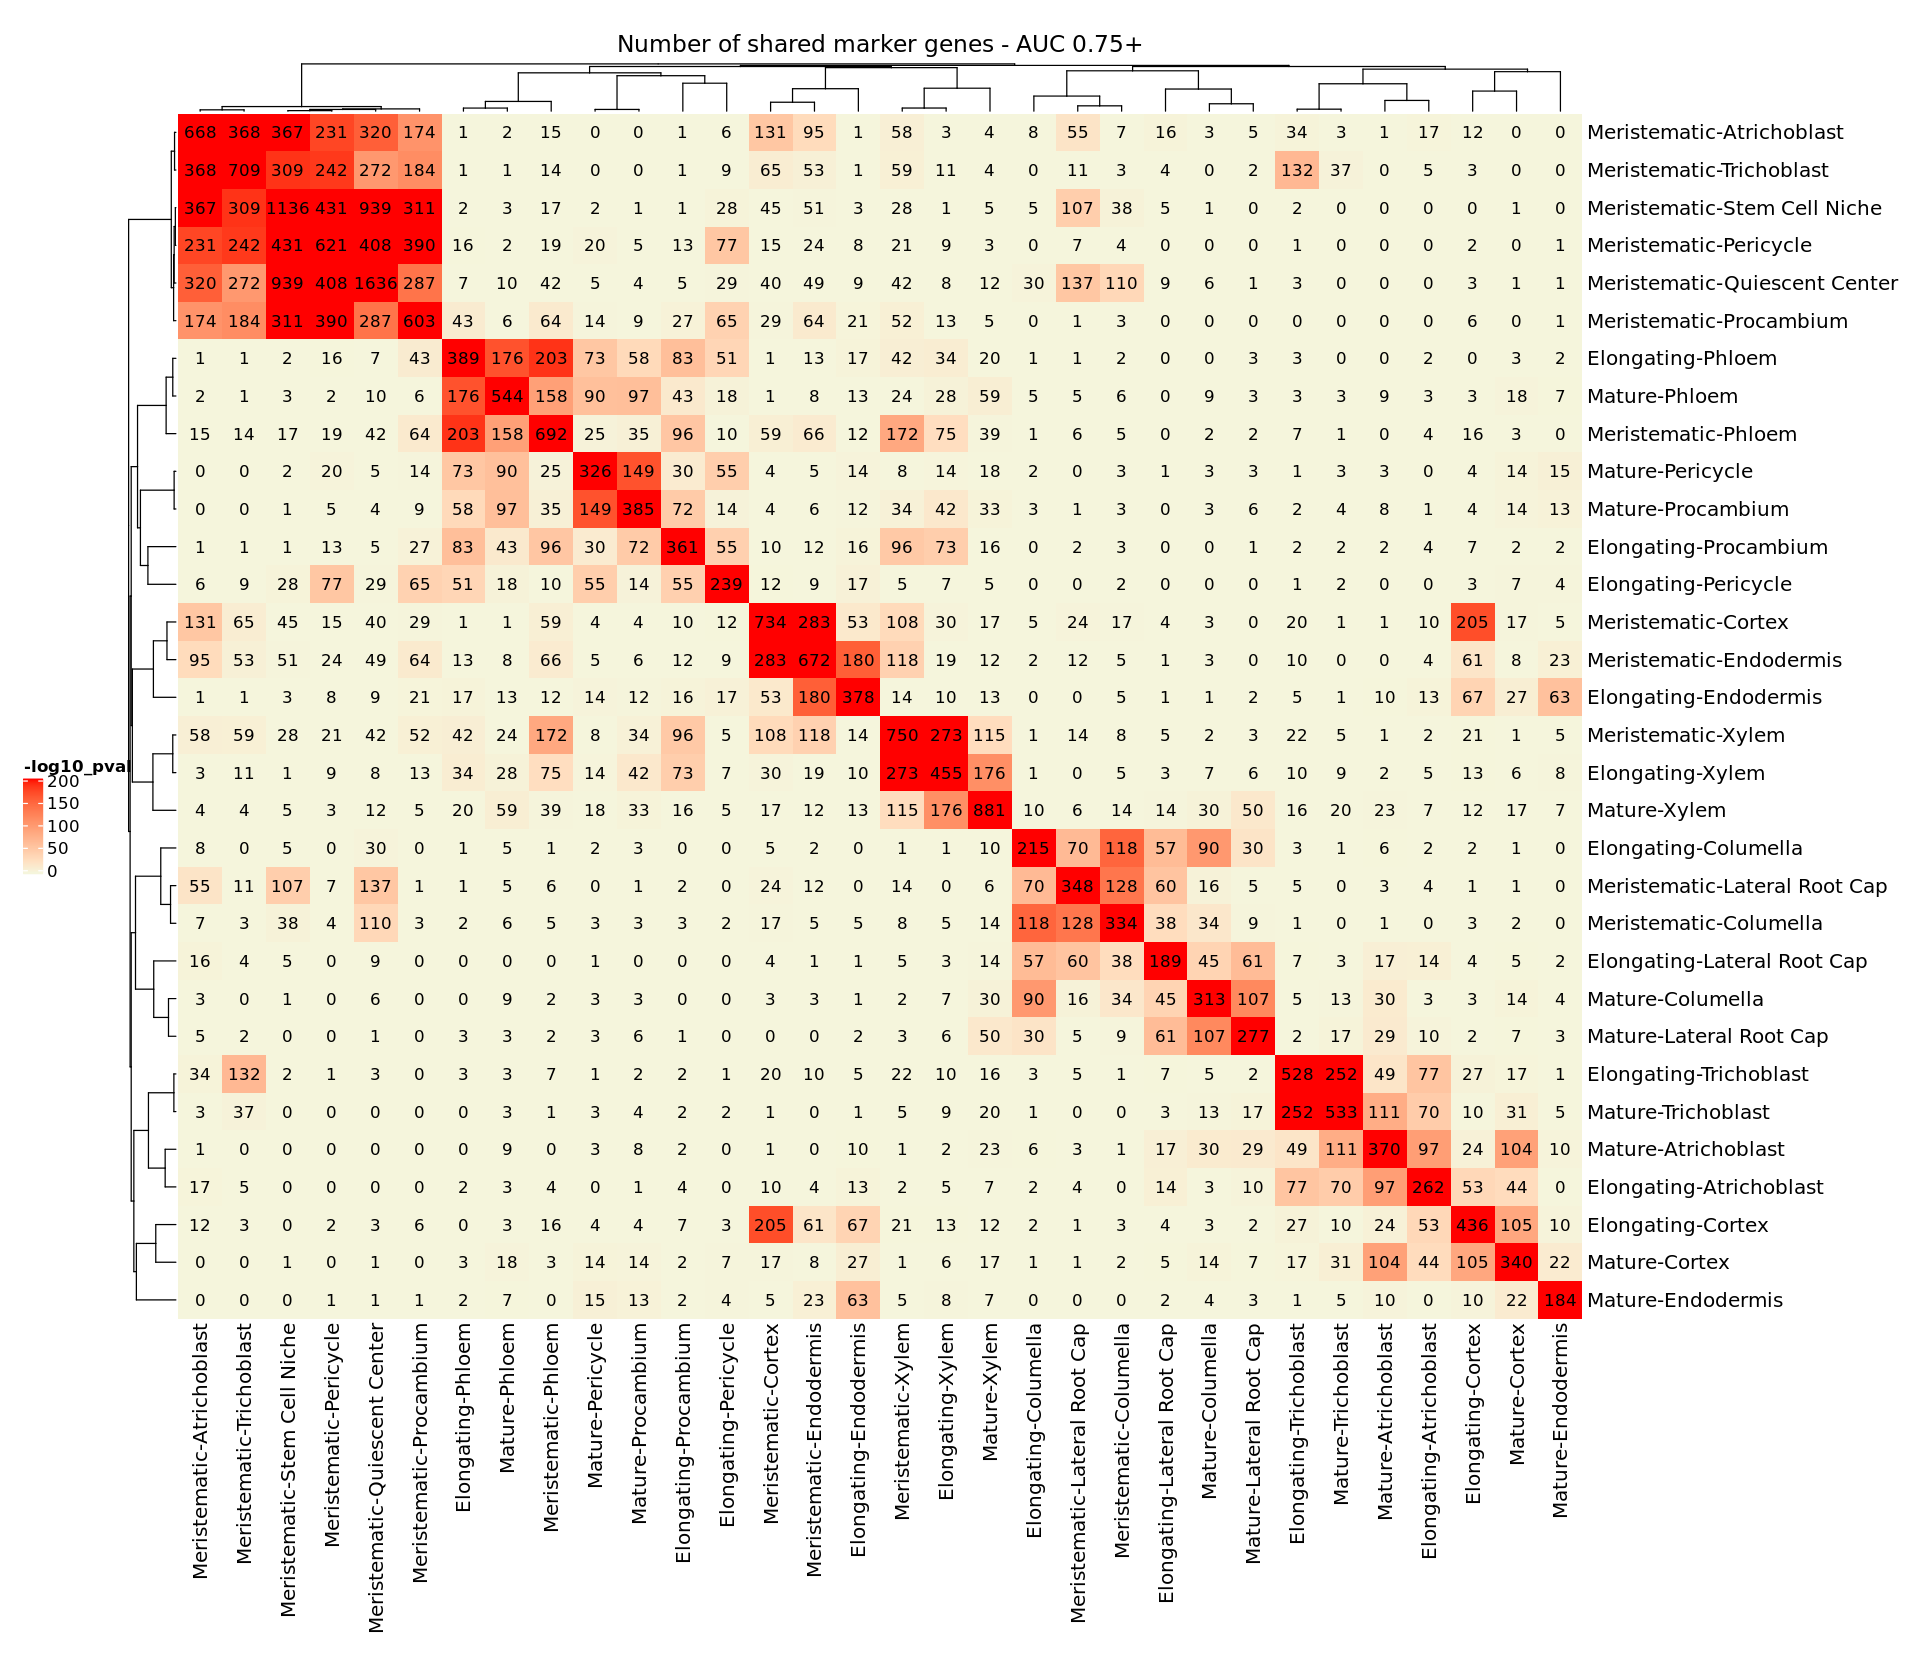

In [48]:
options(repr.plot.width = 16, repr.plot.height = 14)


markers_sel <- filter(cell_time_Clust_Markers, myAUC>=0.75) %>% select(gene, cluster)

markers_list <- split(markers_sel, f=markers_sel$cluster)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))
 
## GeneOverlap 

# number of integrated features

genome_size <- 17513L

#compare all lists
gom.self <- newGOM(markers_list, markers_list, genome.size=genome_size)


int <- getNestedList(gom.self, "intersection")
int_matrix <- getMatrix(gom.self, "intersection")
p.val <- getMatrix(gom.self, "pval")
JC <- getMatrix(gom.self, "Jaccard")

# log of p.val for intersection
p.val_log <- -log10(p.val + 1e-200)


olap <- Heatmap(p.val_log, 
                name = "-log10_pval", 
                col = colorRamp2(c(0, 200), 
                                 c("beige", "red")), 
                column_title = "Number of shared marker genes - AUC 0.75+", 
                cluster_rows = T,
                cluster_columns = T, 
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                clustering_distance_rows = "pearson",
                clustering_distance_columns = "pearson", 
                show_column_dend = TRUE, cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))
}) 
                        
                        # padding - bottom, left, top, right
draw(olap, padding = unit(c(15, 5, 5, 10), "mm"), heatmap_legend_side = "left")

In [49]:

markers_sel <- filter(cell_time_Clust_Markers, myAUC>=0.75) %>% select(gene, cluster)

markers_list <- split(markers_sel, f=markers_sel$cluster)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))

cluster_GO <- gost(markers_list, organism = "athaliana", correction_method = "fdr", significant = F, multi_query = F)

cluster_GO_df <- cluster_GO[[1]]

cluster_GO_sig <- filter(cluster_GO_df, p_value<=0.01)

# top  terms for each cluster

cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(query) %>%
  top_n(5, wt = -p_value) %>%
  arrange(desc(p_value)) -> top_GO

GO_n <- cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(term_id) %>%
  tally() %>%
  arrange(desc(n))


GO_n <- dplyr::rename(GO_n, "n_clusters"=n)

cluster_GO_sig_n <- left_join(cluster_GO_sig, GO_n)

# get all terms for the top ones so that all clusters have values

top_GO_all <- filter(cluster_GO_df, term_id %in% top_GO$term_id)


#spread and plot


top_GO_sel <- select(top_GO_all, query, p_value, term_id, term_name)

spread_GO <- spread(top_GO_sel, key = query, p_value)

spread_GO[is.na(spread_GO)] <- 1

spread_GO_m <- as.matrix(-log10(spread_GO[3:ncol(spread_GO)]))
rownames(spread_GO_m) <- spread_GO$term_name



Joining, by = "term_id"



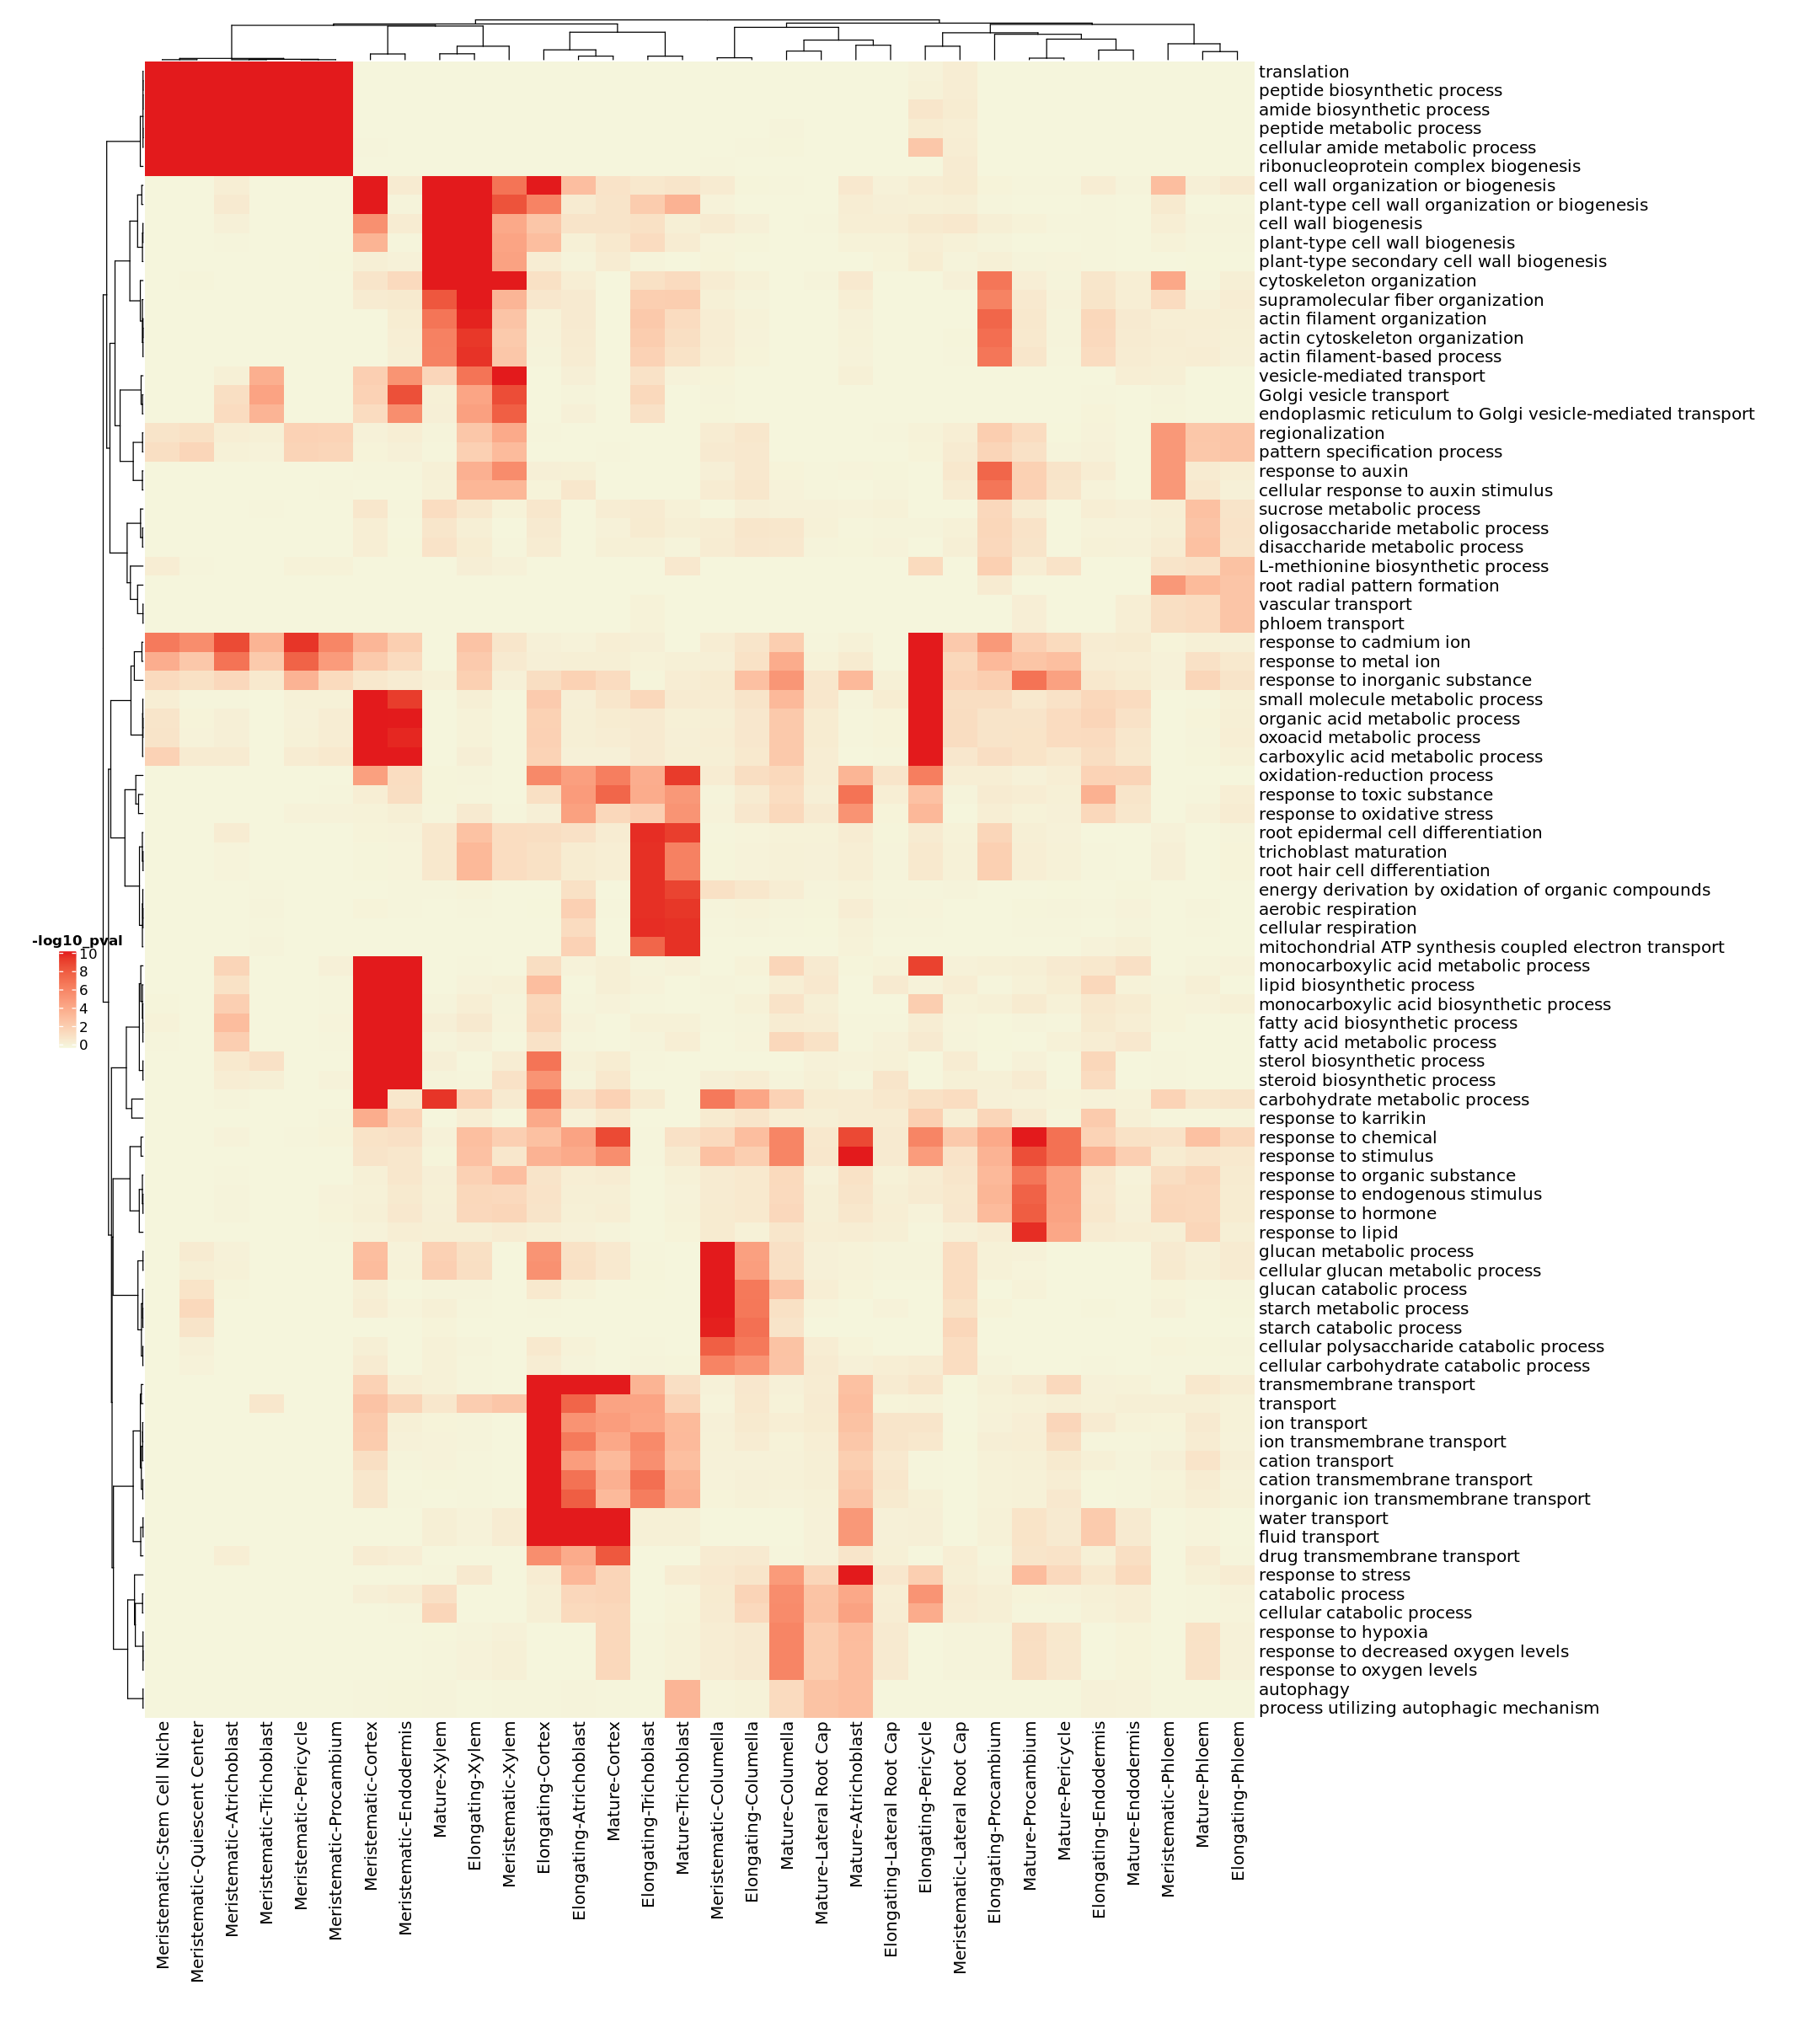

In [50]:
options(repr.plot.width = 18, repr.plot.height = 20)

GO_hm <- Heatmap(spread_GO_m, 
                 name = "-log10_pval", 
                 heatmap_legend_param = list(title_position="topcenter", color_bar = "continuous"), 
                 col = colorRamp2(c(0, 10), 
                                  c("beige", "#e31a1c")), 
                 cluster_rows = T,
                 cluster_columns = T, 
                 use_raster= FALSE, 
                 show_column_names = TRUE, 
                 show_row_names = TRUE, 
                 show_row_dend = TRUE, 
                 show_column_dend = TRUE, 
                 clustering_distance_rows = "pearson",
                 clustering_distance_columns = "pearson", 
                 row_names_gp = gpar(fontsize = 12)) 


# padding - bottom, left, top, right
draw(GO_hm, padding = unit(c(15, 15, 5, 80), "mm"), heatmap_legend_side = "left")

In [51]:
cell_time_Clust_Markers$clus_to_split <- cell_time_Clust_Markers$cluster
cell_time_Clust_Markers <- separate(cell_time_Clust_Markers, clus_to_split, into=c("timezone", "celltype"), sep="-")


In [52]:
cell_time_Clust_Markers$cluster <- as.character(cell_time_Clust_Markers$cluster)


cell_time_Clust_Markers$timezone <- factor(cell_time_Clust_Markers$timezone, levels=c("Mature", "Elongating", "Meristematic"))

ct_levels <- names(table(rc.integrated$celltype.anno))

cell_time_Clust_Markers$celltype <- factor(cell_time_Clust_Markers$celltype, levels=ct_levels)

cell_time_Clust_Markers <- arrange(cell_time_Clust_Markers, timezone) %>% arrange(celltype)


cell_time_Clust_Markers

myAUC avg_diff  power pct.1 pct.2 cluster                       gene     
1     0.960 4.434609  0.920 0.958 0.092 Mature-Procambium             AT1G61660
2     0.957 3.968631  0.914 0.946 0.092 Mature-Procambium             AT3G13730
3     0.950 4.181996  0.900 0.941 0.094 Mature-Procambium             AT1G66600
4     0.955 3.858934  0.910 0.951 0.094 Mature-Procambium             AT4G32860
5     0.954 3.945702  0.908 0.948 0.104 Mature-Procambium             AT1G33700
6     0.939 3.597071  0.878 0.942 0.135 Mature-Procambium             AT2G28660
7     0.966 3.086131  0.932 0.988 0.146 Mature-Procambium             AT1G76410
8     0.939 3.312503  0.878 0.950 0.170 Mature-Procambium             AT5G65870
9     0.960 3.010779  0.920 0.987 0.189 Mature-Procambium             AT1G63180
10    0.944 3.002316  0.888 0.949 0.123 Mature-Procambium             AT1G22710
11    0.964 2.949445  0.928 0.990 0.192 Mature-Procambium             AT1G64660
12    0.930 3.421682  0.860 0.953 0.210 Mature-Procambium             AT4G31110
13    0.947 3.265976  0.894 0.982 0.256 Mature-Procambium             AT4G02590
14    0.889 4.320074  0.778 0.843 0.077 Mature-Procambium             AT1G59740
15    0.937 3.874566  0.874 0.953 0.252 Mature-Procambium             AT2G37760
16    0.918 3.266417  0.836 0.903 0.127 Mature-Procambium             AT3G26830
17    0.903 3.705681  0.806 0.876 0.135 Mature-Procambium             AT2G37770
18    0.941 2.860395  0.882 0.940 0.133 Mature-Procambium             AT1G14890
19    0.912 3.150949  0.824 0.894 0.100 Mature-Procambium             AT5G67090
20    0.909 3.618716  0.818 0.909 0.180 Mature-Procambium             AT5G50450
21    0.943 3.139117  0.886 0.966 0.250 Mature-Procambium             AT4G34230
22    0.928 3.536780  0.856 0.952 0.249 Mature-Procambium             AT1G64720
23    0.921 3.220675  0.842 0.932 0.197 Mature-Procambium             AT3G54140
24    0.932 3.664726  0.864 0.955 0.270 Mature-Procambium             AT4G37260
25    0.936 2.970859  0.872 0.965 0.217 Mature-Procambium             AT4G33700
26    0.929 2.801056  0.858 0.914 0.098 Mature-Procambium             AT1G71695
27    0.932 3.643668  0.864 0.950 0.283 Mature-Procambium             AT4G12080
28    0.930 2.806964  0.860 0.925 0.144 Mature-Procambium             AT1G23800
29    0.922 3.138755  0.844 0.945 0.221 Mature-Procambium             AT4G34590
30    0.900 3.111832  0.800 0.899 0.131 Mature-Procambium             AT1G15415
⋮     ⋮     ⋮         ⋮     ⋮     ⋮     ⋮                             ⋮        
16479 0.758 0.8817055 0.516 0.676 0.213 Meristematic-Quiescent Center AT1G11720
16480 0.764 0.9034369 0.528 0.735 0.311 Meristematic-Quiescent Center AT2G47640
16481 0.753 1.1408003 0.506 0.697 0.255 Meristematic-Quiescent Center AT4G09140
16482 0.752 0.9666352 0.504 0.710 0.235 Meristematic-Quiescent Center AT3G18240
16483 0.759 0.8921020 0.518 0.701 0.250 Meristematic-Quiescent Center AT2G44270
16484 0.768 0.7246809 0.536 0.792 0.375 Meristematic-Quiescent Center AT5G56010
16485 0.763 0.8777123 0.526 0.707 0.279 Meristematic-Quiescent Center AT5G06060
16486 0.755 0.9218126 0.510 0.721 0.257 Meristematic-Quiescent Center AT1G19520
16487 0.754 0.8299999 0.508 0.733 0.258 Meristematic-Quiescent Center AT3G61530
16488 0.750 1.1706780 0.500 0.700 0.266 Meristematic-Quiescent Center AT4G15640
16489 0.750 1.0575788 0.500 0.701 0.243 Meristematic-Quiescent Center AT2G44040
16490 0.755 1.0463468 0.510 0.661 0.234 Meristematic-Quiescent Center AT3G50340
16491 0.762 0.7585482 0.524 0.702 0.258 Meristematic-Quiescent Center AT4G29430
16492 0.756 1.0212937 0.512 0.670 0.256 Meristematic-Quiescent Center AT4G37660
16493 0.762 0.8152083 0.524 0.776 0.350 Meristematic-Quiescent Center AT4G02450
16494 0.756 0.8898193 0.512 0.700 0.249 Meristematic-Quiescent Center AT4G26670
16495 0.753 1.1239899 0.506 0.526 0.198 Meristematic-Quiescent Center AT1G07820
16496 0.753 0.8308445 0.506 0.588 0.117 Meristematic-Quiescent Center AT5G60250
16497 

In [53]:
write.csv(cell_time_Clust_Markers, "./supp_data/Atlas_cell_time_combined_ROC_Clust_Markers_20200527.csv", row.names=F)

## Selected Markers for Cell type and developmental stage specific dot plot

SCR, MYB36 and CASP1 were selected for the endodermis because they are highlighted later in the manuscript and are highly enrichened. Note that MYB36 is expressed in all developmental stages of endodermis, but is highest in the elongation zone. 

For others, I took the top 20 combined rank and gave preference for those that were specific (i.e. n<=1) or where known markers


In [54]:
(Markers_to_plot <- read_csv("./supp_data/Atlas_cell_time_combined_ROC_Clust_Markers_20200527_to_plot.csv") %>% filter(plot=="y"))

Parsed with column specification:
cols(
  myAUC = col_double(),
  avg_diff = col_double(),
  power = col_double(),
  pct.1 = col_double(),
  pct.2 = col_double(),
  cluster = col_character(),
  gene = col_character(),
  n = col_double(),
  Name = col_character(),
  cluster_gene = col_character(),
  pct.diff = col_double(),
  pct.diff_rank = col_double(),
  avg_diff_rank = col_double(),
  myAUC_rank = col_double(),
  combined_rank = col_double(),
  timezone = col_character(),
  celltype = col_character(),
  plot = col_character()
)



myAUC avg_diff power pct.1 pct.2 cluster                       gene      n
1  0.960 4.434609 0.920 0.958 0.092 Mature-Procambium             AT1G61660 2
2  0.976 4.745681 0.952 0.958 0.061 Elongating-Procambium         AT4G14650 1
3  0.914 2.518556 0.828 0.907 0.146 Meristematic-Procambium       AT5G19260 1
4  0.995 6.848001 0.990 0.991 0.015 Mature-Xylem                  AT5G60020 1
5  0.993 4.717875 0.986 0.994 0.029 Elongating-Xylem              AT1G68810 3
6  0.968 4.617449 0.936 0.963 0.086 Meristematic-Xylem            AT2G34060 1
7  0.961 4.399070 0.922 0.932 0.053 Mature-Phloem                 AT3G04300 2
8  0.975 3.246831 0.950 0.986 0.077 Elongating-Phloem             AT5G59090 3
9  0.973 3.426909 0.946 0.961 0.045 Meristematic-Phloem           AT1G79430 3
10 0.951 3.455965 0.902 0.943 0.076 Mature-Pericycle              AT1G16310 1
11 0.946 3.477806 0.892 0.979 0.268 Elongating-Pericycle          AT2G44160 1
12 0.801 2.551537 0.602 0.777 0.165 Meristematic-Pericycle        AT2G14880 1
13 0.875 4.177932 0.750 0.849 0.089 Mature-Endodermis             AT2G36100 1
14 0.987 3.673766 0.974 0.997 0.064 Elongating-Endodermis         AT5G57620 3
15 0.940 4.375770 0.880 0.934 0.110 Meristematic-Endodermis       AT3G54220 1
16 0.908 4.189032 0.816 0.881 0.119 Mature-Cortex                 AT4G09760 1
17 0.931 4.669360 0.862 0.912 0.106 Elongating-Cortex             AT5G64620 2
18 0.947 3.836129 0.894 0.950 0.146 Meristematic-Cortex           AT5G02000 2
19 0.985 4.874457 0.970 0.979 0.066 Mature-Trichoblast            AT4G25820 1
20 0.923 4.431998 0.846 0.902 0.079 Elongating-Trichoblast        AT2G34940 1
21 0.895 3.280722 0.790 0.860 0.102 Meristematic-Trichoblast      AT1G27140 2
22 0.958 3.878814 0.916 0.963 0.131 Mature-Atrichoblast           AT3G01970 1
23 0.981 4.614398 0.962 0.993 0.292 Elongating-Atrichoblast       AT5G60950 1
24 0.962 4.487458 0.924 0.961 0.130 Meristematic-Atrichoblast     AT5G51500 1
25 0.921 4.963859 0.842 0.860 0.046 Mature-Lateral Root Cap       AT3G25950 1
26 0.960 4.056060 0.920 0.957 0.109 Elongating-Lateral Root Cap   AT2G35770 1
27 0.957 3.218172 0.914 0.956 0.119 Meristematic-Lateral Root Cap AT4G37160 2
28 0.908 3.673310 0.816 0.878 0.158 Mature-Columella              AT4G20780 1
29 0.929 3.121659 0.858 0.965 0.274 Elongating-Columella          AT5G23820 3
30 0.877 3.544089 0.754 0.781 0.057 Meristematic-Columella        AT3G03620 1
31 0.959 3.152680 0.918 0.963 0.138 Meristematic-Stem Cell Niche  AT4G25630 4
32 0.932 4.338515 0.864 0.907 0.074 Meristematic-Quiescent Center AT5G48360 1
   Name      cluster_gene                            pct.diff pct.diff_rank
1  BHLH112   Mature-Procambium_AT2G39795             0.866      1          
2  AT4G14650 Elongating-Procambium_AT3G62630         0.897      1          
3  FAF3      Meristematic-Procambium_AT1G09590       0.761      8          
4  LAC17     Mature-Xylem_AT5G19750                  0.976      8          
5  BHLH30    Elongating-Xylem_AT1G28250              0.965      1          
6  PER19     Meristematic-Xylem_AT2G16780            0.877      9          
7  AT3G04300 Mature-Phloem_AT1G27400                 0.879      6          
8  SBT4.12   Elongating-Phloem_AT4G24830             0.909      1          
9  APL       Meristematic-Phloem_AT3G25290           0.916      1          
10 MTP10     Mature-Pericycle_AT2G28790              0.867      3          
11 MTHFR2    Elongating-Pericycle_AT3G02677          0.711     17          
12 AT2G14880 Meristematic-Pericycle_AT2G33847        0.612    205          
13 CASP1     Mature-Endodermis_AT3G14000             0.760     10          
14 MYB36     Elongating-Endodermis_AT3G14560         0.933      1          
15 SCR       Meristematic-Endodermis_AT2G43800       0.824     19          
16 AT4G09760 Mature-Cortex_AT1G30440                 0.762     18          
17 C/VIF2    Elongating-Cortex_AT4G25740             0.806     16          
18 AT5G02000 Meristematic-Cortex_AT5G22330           0.804   

In [55]:
(c_levels <- unique(Markers_to_plot$cluster))

[1] "Mature-Procambium"             "Elongating-Procambium"        
 [3] "Meristematic-Procambium"       "Mature-Xylem"                 
 [5] "Elongating-Xylem"              "Meristematic-Xylem"           
 [7] "Mature-Phloem"                 "Elongating-Phloem"            
 [9] "Meristematic-Phloem"           "Mature-Pericycle"             
[11] "Elongating-Pericycle"          "Meristematic-Pericycle"       
[13] "Mature-Endodermis"             "Elongating-Endodermis"        
[15] "Meristematic-Endodermis"       "Mature-Cortex"                
[17] "Elongating-Cortex"             "Meristematic-Cortex"          
[19] "Mature-Trichoblast"            "Elongating-Trichoblast"       
[21] "Meristematic-Trichoblast"      "Mature-Atrichoblast"          
[23] "Elongating-Atrichoblast"       "Meristematic-Atrichoblast"    
[25] "Mature-Lateral Root Cap"       "Elongating-Lateral Root Cap"  
[27] "Meristematic-Lateral Root Cap" "Mature-Columella"             
[29] "Elongating-Columella"          "Meristematic-Columella"       
[31] "Meristematic-Stem Cell Niche"  "Meristematic-Quiescent Center"

In [56]:
ct_to_plt_Names <- Markers_to_plot$Name
ct_to_plt_genes <- Markers_to_plot$gene

In [57]:
table(rc.integrated$cell_time_final)


      Elongating-Atrichoblast          Elongating-Columella 
                         5223                          2405 
            Elongating-Cortex         Elongating-Endodermis 
                         5698                          4801 
  Elongating-Lateral Root Cap          Elongating-Pericycle 
                         4273                          6265 
            Elongating-Phloem         Elongating-Procambium 
                         4078                          6275 
       Elongating-Trichoblast              Elongating-Xylem 
                         4598                          2752 
          Mature-Atrichoblast              Mature-Columella 
                         3661                          6834 
                Mature-Cortex             Mature-Endodermis 
                         2822                          4273 
      Mature-Lateral Root Cap              Mature-Pericycle 
                         2780                          3670 
                Mature-

In [58]:
rc.integrated$cell_time_final <- factor(rc.integrated$cell_time_final, levels=rev(c_levels))
Idents(rc.integrated) <- "cell_time_final"
table(rc.integrated$cell_time_final)


Meristematic-Quiescent Center  Meristematic-Stem Cell Niche 
                         1195                          1807 
       Meristematic-Columella          Elongating-Columella 
                         3600                          2405 
             Mature-Columella Meristematic-Lateral Root Cap 
                         6834                          6895 
  Elongating-Lateral Root Cap       Mature-Lateral Root Cap 
                         4273                          2780 
    Meristematic-Atrichoblast       Elongating-Atrichoblast 
                         4096                          5223 
          Mature-Atrichoblast      Meristematic-Trichoblast 
                         3661                          3330 
       Elongating-Trichoblast            Mature-Trichoblast 
                         4598                          3881 
          Meristematic-Cortex             Elongating-Cortex 
                         1686                          5698 
                Mature-

In [59]:
(breaks <- rev(ct_to_plt_genes))

[1] "AT5G48360" "AT4G25630" "AT3G03620" "AT5G23820" "AT4G20780" "AT4G37160"
 [7] "AT2G35770" "AT3G25950" "AT5G51500" "AT5G60950" "AT3G01970" "AT1G27140"
[13] "AT2G34940" "AT4G25820" "AT5G02000" "AT5G64620" "AT4G09760" "AT3G54220"
[19] "AT5G57620" "AT2G36100" "AT2G14880" "AT2G44160" "AT1G16310" "AT1G79430"
[25] "AT5G59090" "AT3G04300" "AT2G34060" "AT1G68810" "AT5G60020" "AT5G19260"
[31] "AT4G14650" "AT1G61660"

In [60]:
(labels <- rev(ct_to_plt_Names))

[1] "FH9"       "MED36A"    "DTX24"     "ML3"       "CML42"     "sks15"    
 [7] "SCPL28"    "AT3G25950" "PME60"     "COBL5"     "WRKY45"    "GSTU14"   
[13] "VSR5"      "XTH14"     "AT5G02000" "C/VIF2"    "AT4G09760" "SCR"      
[19] "MYB36"     "CASP1"     "AT2G14880" "MTHFR2"    "MTP10"     "APL"      
[25] "SBT4.12"   "AT3G04300" "PER19"     "BHLH30"    "LAC17"     "FAF3"     
[31] "AT4G14650" "BHLH112"

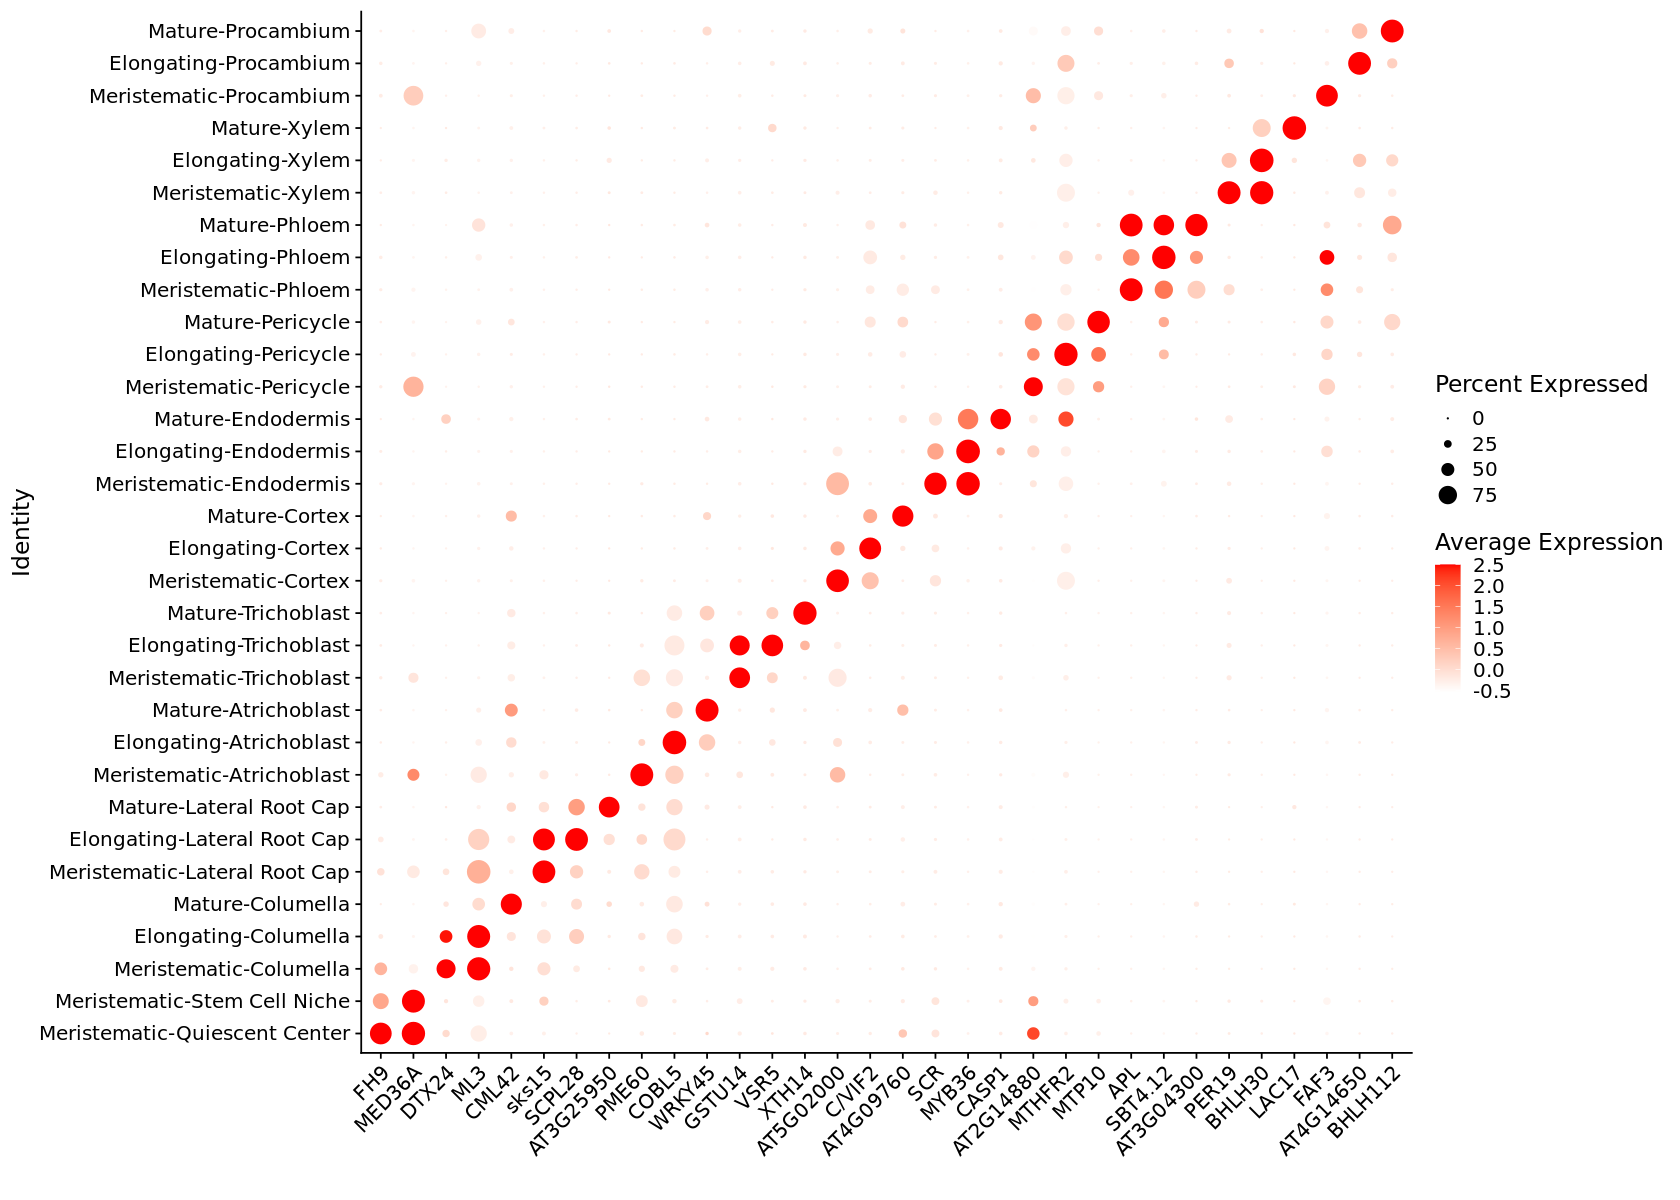

In [61]:
options(repr.plot.width=14, repr.plot.height=10)

DotPlot(object = rc.integrated, features = ct_to_plt_genes, cols = c("white", "red")) + RotatedAxis() + 
scale_x_discrete(breaks=breaks, labels=labels) + xlab("")


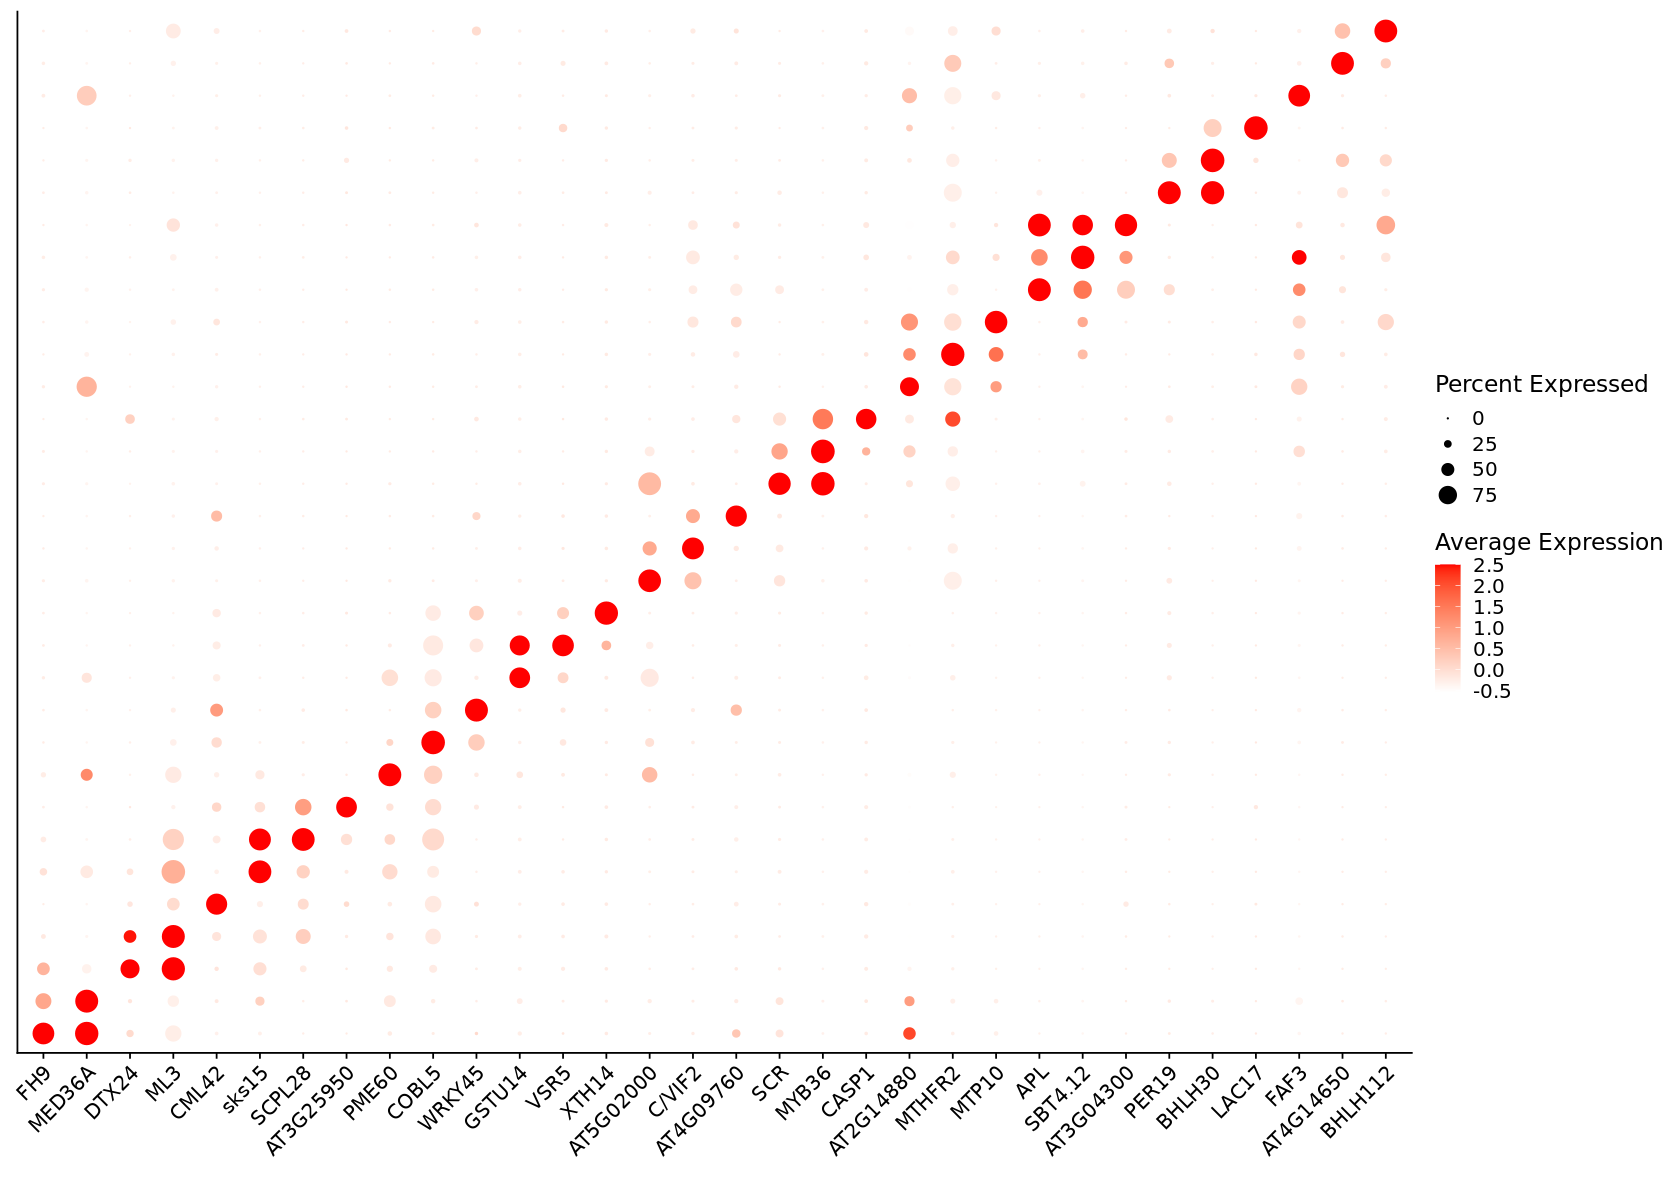

In [62]:
options(repr.plot.width=14, repr.plot.height=10)
dot <- DotPlot(object = rc.integrated, features = ct_to_plt_genes, cols = c("white", "red")) + RotatedAxis() + ylab("")  + theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) + 
scale_x_discrete(breaks=breaks, labels=labels) + xlab("")
dot 

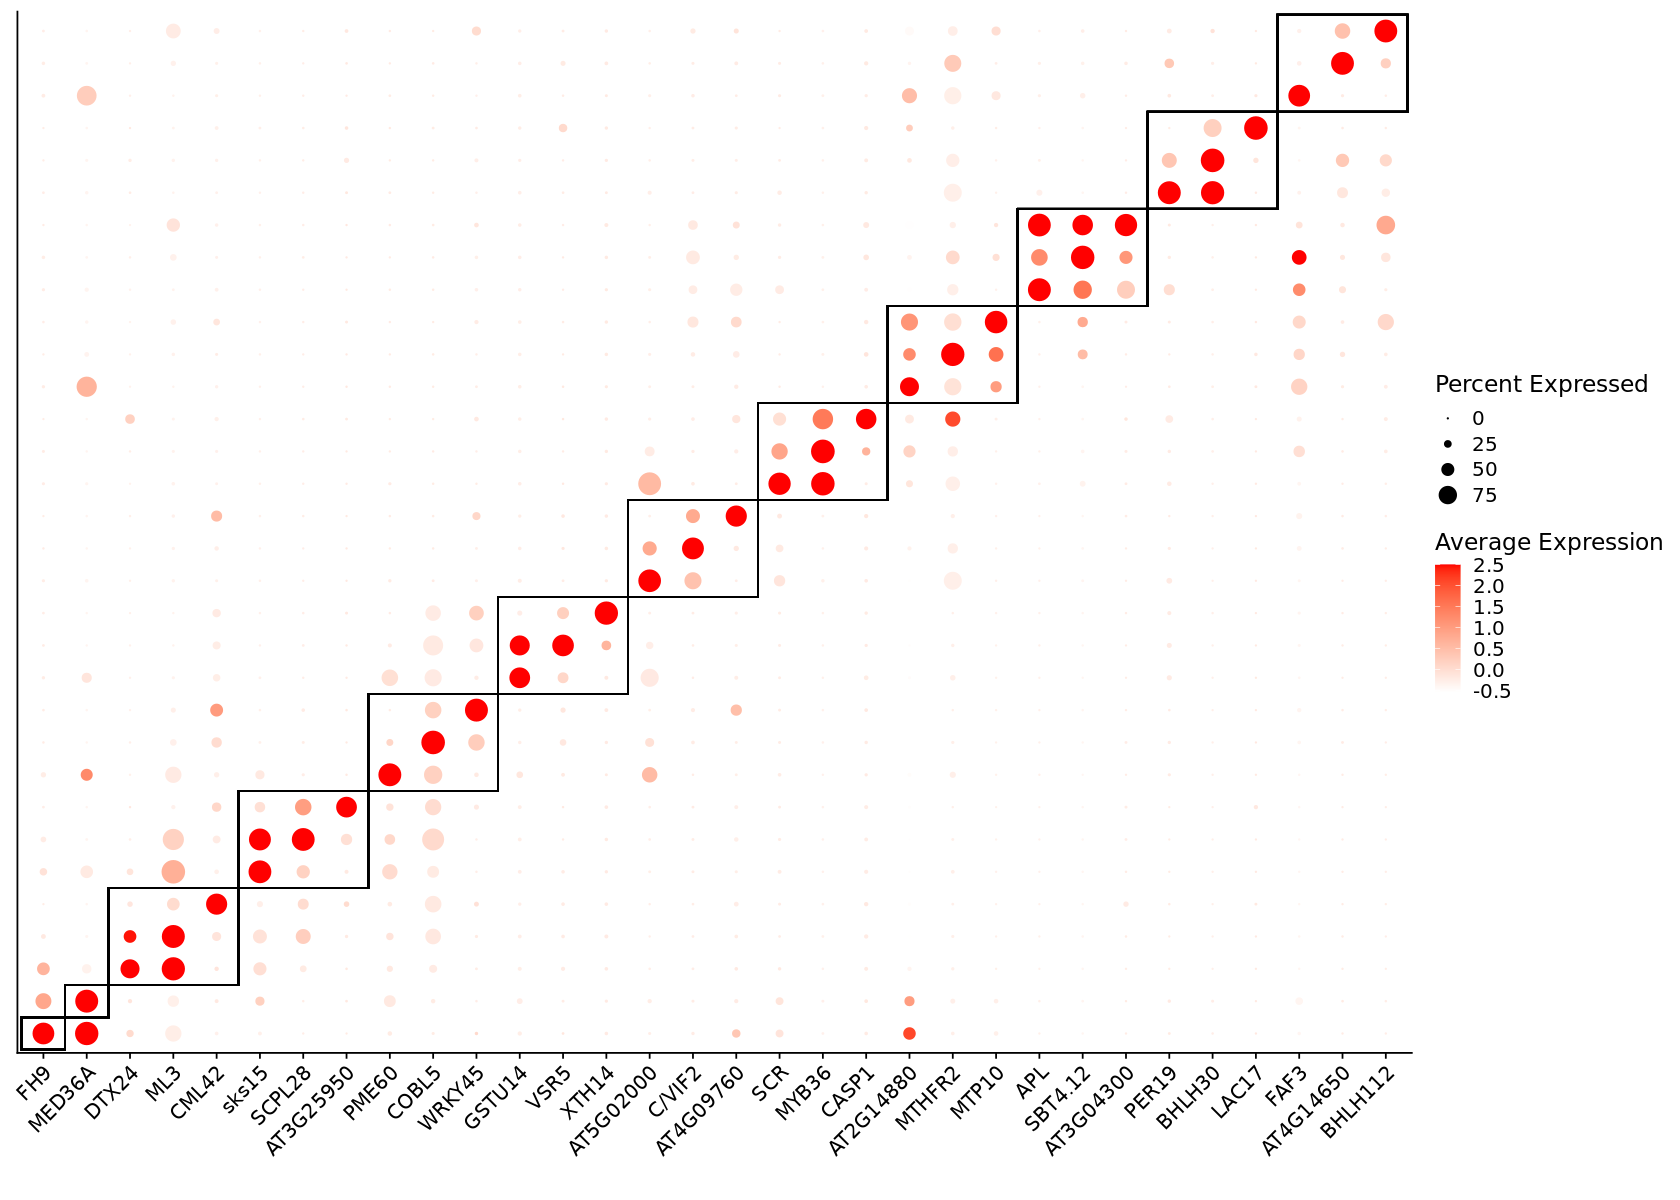

In [63]:
options(repr.plot.width=14, repr.plot.height=10)
dot <- dot + geom_rect(xmin = 0.5, xmax = 1.5, ymin = 0.5, ymax = 1.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 1.5, xmax = 2.5, ymin = 1.5, ymax = 2.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 2.5, xmax = 5.5, ymin = 2.5, ymax = 5.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 5.5, xmax = 8.5, ymin = 5.5, ymax = 8.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 8.5, xmax = 11.5, ymin = 8.5, ymax = 11.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 11.5, xmax = 14.5, ymin = 11.5, ymax = 14.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 14.5, xmax = 17.5, ymin = 14.5, ymax = 17.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 17.5, xmax = 20.5, ymin = 17.5, ymax = 20.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 20.5, xmax = 23.5, ymin = 20.5, ymax = 23.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 23.5, xmax = 26.5, ymin = 23.5, ymax = 26.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 26.5, xmax = 29.5, ymin = 26.5, ymax = 29.5, alpha = 0,fill=alpha("grey",0), color="black") + 
geom_rect(xmin = 29.5, xmax = 32.5, ymin = 29.5, ymax = 32.5, alpha = 0,fill=alpha("grey",0), color="black") 

dot

In [64]:
ann_df <- tibble(timezone=as.character(Markers_to_plot$timezone), 
                celltype= as.character(Markers_to_plot$celltype)) %>% 
mutate(row=dplyr::row_number(), 
col=rep("A")) %>%
group_by(celltype) %>%
mutate(ct_row=dplyr::row_number()) %>%
ungroup() %>%
mutate(Label=celltype)

ann_df$Label[ann_df$ct_row!=2] <- " "
ann_df$Label[ann_df$celltype=="Stem Cell Niche"] <- "Stem Cell Niche"
ann_df$Label[ann_df$celltype=="Quiescent Center"] <- "Quiescent Center"

ann_df$row <- factor(ann_df$row)
ann_df$timezone <- factor(ann_df$timezone, levels=c("Meristematic", "Elongating", "Mature"))


In [65]:
ann_df

timezone     celltype         row col ct_row Label           
1  Mature       Procambium       1   A   1                      
2  Elongating   Procambium       2   A   2      Procambium      
3  Meristematic Procambium       3   A   3                      
4  Mature       Xylem            4   A   1                      
5  Elongating   Xylem            5   A   2      Xylem           
6  Meristematic Xylem            6   A   3                      
7  Mature       Phloem           7   A   1                      
8  Elongating   Phloem           8   A   2      Phloem          
9  Meristematic Phloem           9   A   3                      
10 Mature       Pericycle        10  A   1                      
11 Elongating   Pericycle        11  A   2      Pericycle       
12 Meristematic Pericycle        12  A   3                      
13 Mature       Endodermis       13  A   1                      
14 Elongating   Endodermis       14  A   2      Endodermis      
15 Meristematic Endodermis       15  A   3                      
16 Mature       Cortex           16  A   1                      
17 Elongating   Cortex           17  A   2      Cortex          
18 Meristematic Cortex           18  A   3                      
19 Mature       Trichoblast      19  A   1                      
20 Elongating   Trichoblast      20  A   2      Trichoblast     
21 Meristematic Trichoblast      21  A   3                      
22 Mature       Atrichoblast     22  A   1                      
23 Elongating   Atrichoblast     23  A   2      Atrichoblast    
24 Meristematic Atrichoblast     24  A   3                      
25 Mature       Lateral Root Cap 25  A   1                      
26 Elongating   Lateral Root Cap 26  A   2      Lateral Root Cap
27 Meristematic Lateral Root Cap 27  A   3                      
28 Mature       Columella        28  A   1                      
29 Elongating   Columella        29  A   2      Columella       
30 Meristematic Columella        30  A   3                      
31 Meristematic Stem Cell Niche  31  A   1      Stem Cell Niche 
32 Meristematic Quiescent Center 32  A   1      Quiescent Center

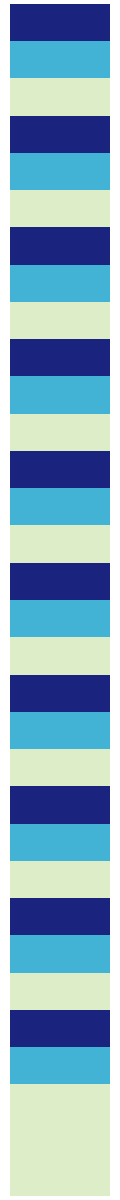

In [66]:
options(repr.plot.width=1, repr.plot.height=10)
(time_ann_p <- ann_df %>% ggplot(aes(x=col, y=rev(row), fill=timezone)) + geom_tile() + scale_fill_manual(values = c("#DCEDC8", "#42B3D5", "#1A237E")) + theme_nothing())

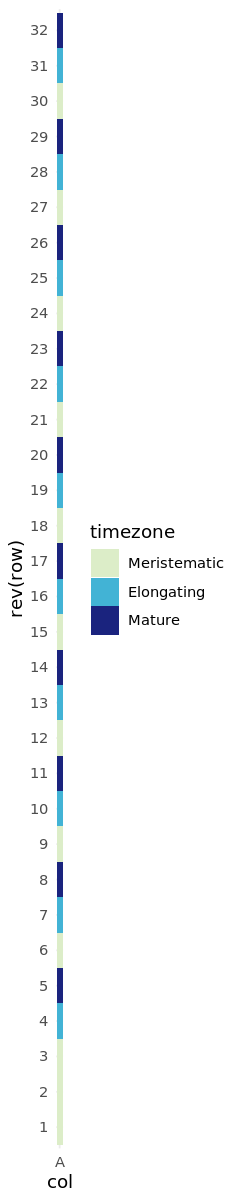

In [67]:
options(repr.plot.width=2, repr.plot.height=10)
ann_df %>% ggplot(aes(x=col, y=rev(row), fill=timezone)) + geom_tile() + scale_fill_manual(values = c("#DCEDC8", "#42B3D5", "#1A237E")) + theme_minimal()

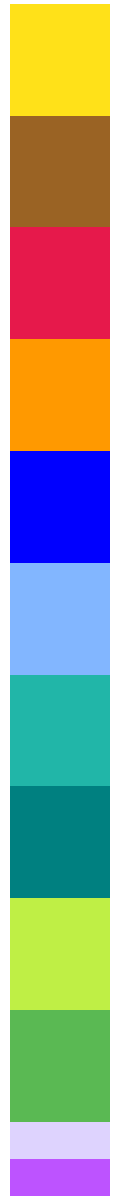

In [68]:
options(repr.plot.width=1, repr.plot.height=10)

ann_df$celltype <- factor(ann_df$celltype, levels = order[sort(match(unique(ann_df$celltype),order))])

color <- palette[sort(match(unique(ann_df$celltype),order))]

(cell_ann_p <- ann_df %>% ggplot(aes(x=col, y=rev(row), fill=celltype)) + geom_tile() + scale_fill_manual(values = color) + theme_nothing())

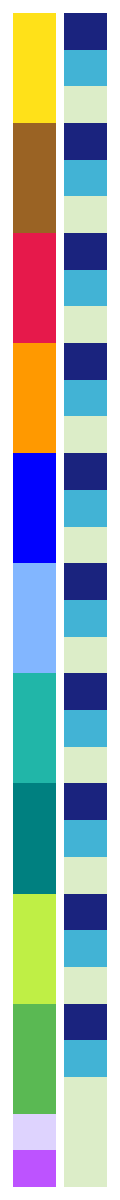

In [69]:
options(repr.plot.width=1, repr.plot.height=10)
cell_ann_p | time_ann_p

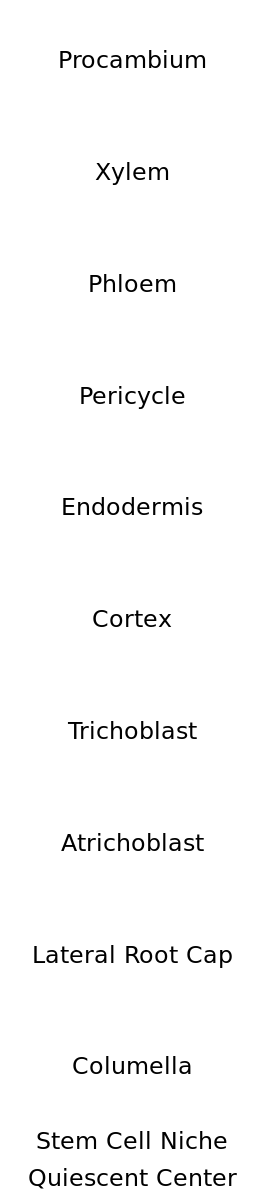

In [70]:
options(repr.plot.width=2.2, repr.plot.height=10)
(text_ann_p <- ann_df %>% ggplot(aes(x=col, y=rev(row), label=Label)) + geom_text(size = 5) + theme(plot.margin = margin(0, 0, 35, 35, "cm")) + theme_nothing())

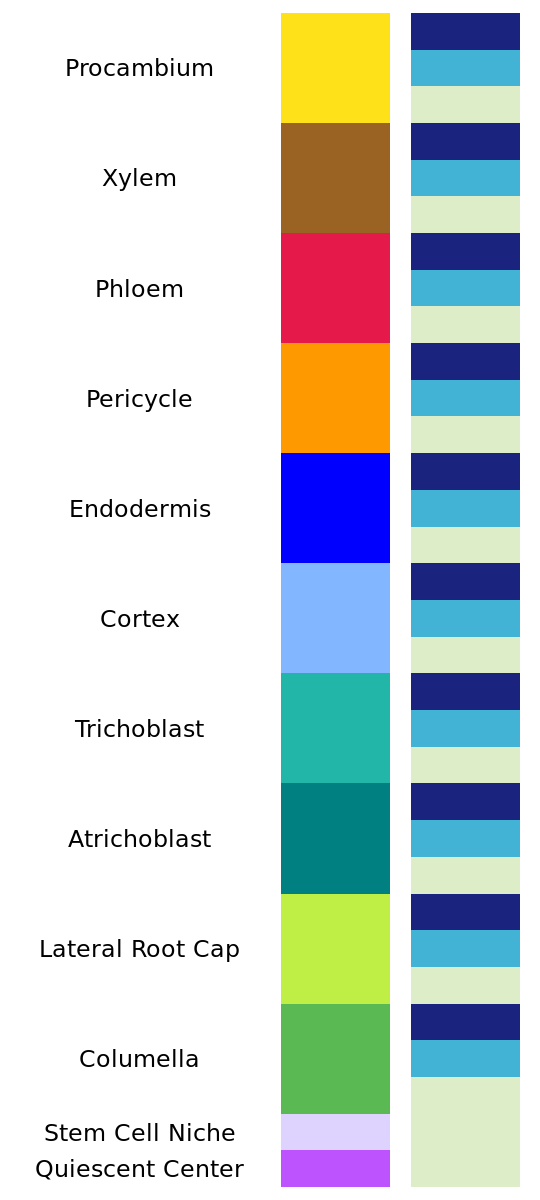

In [71]:
options(repr.plot.width=4.5, repr.plot.height=10)
(c_ann <- text_ann_p | (cell_ann_p | time_ann_p))

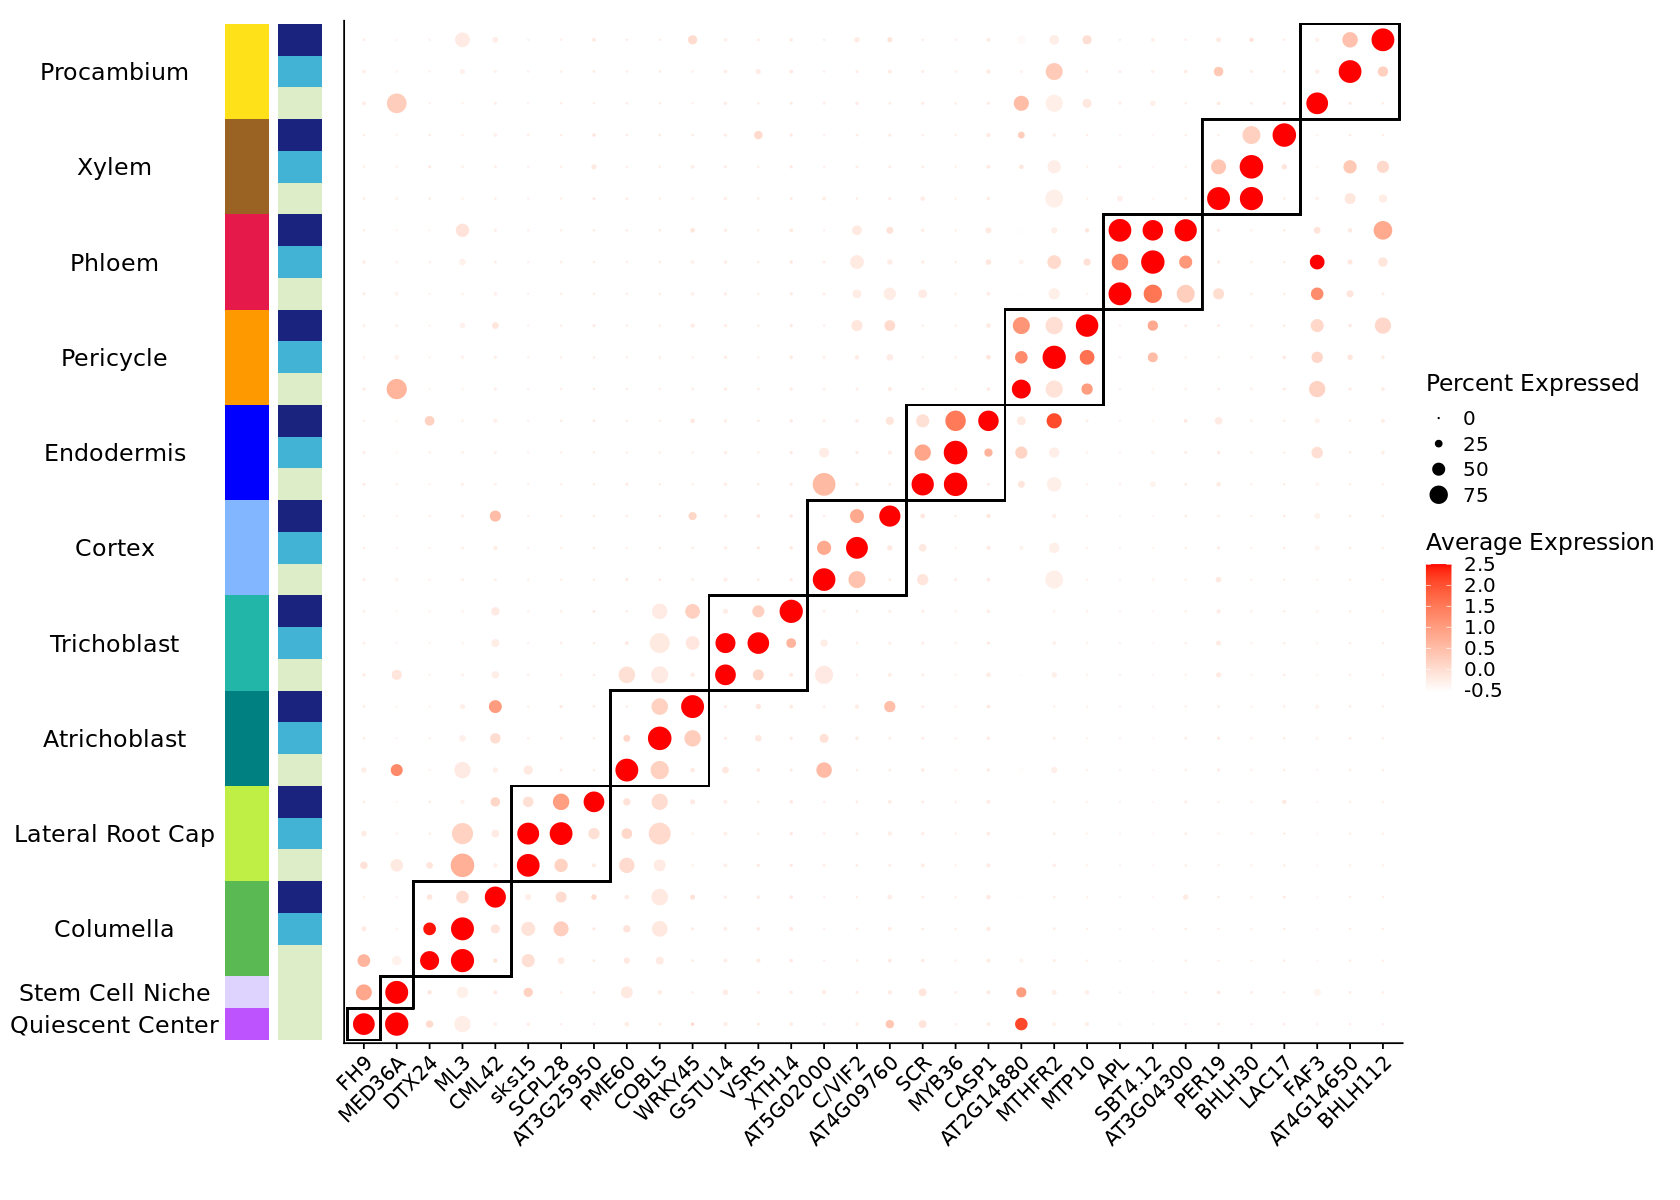

In [72]:
options(repr.plot.width=14, repr.plot.height=10)
combined_marker_plot <- text_ann_p + cell_ann_p + time_ann_p + dot + patchwork::plot_layout(widths = c(0.8,0.2,0.2,4), nrow=1)
combined_marker_plot

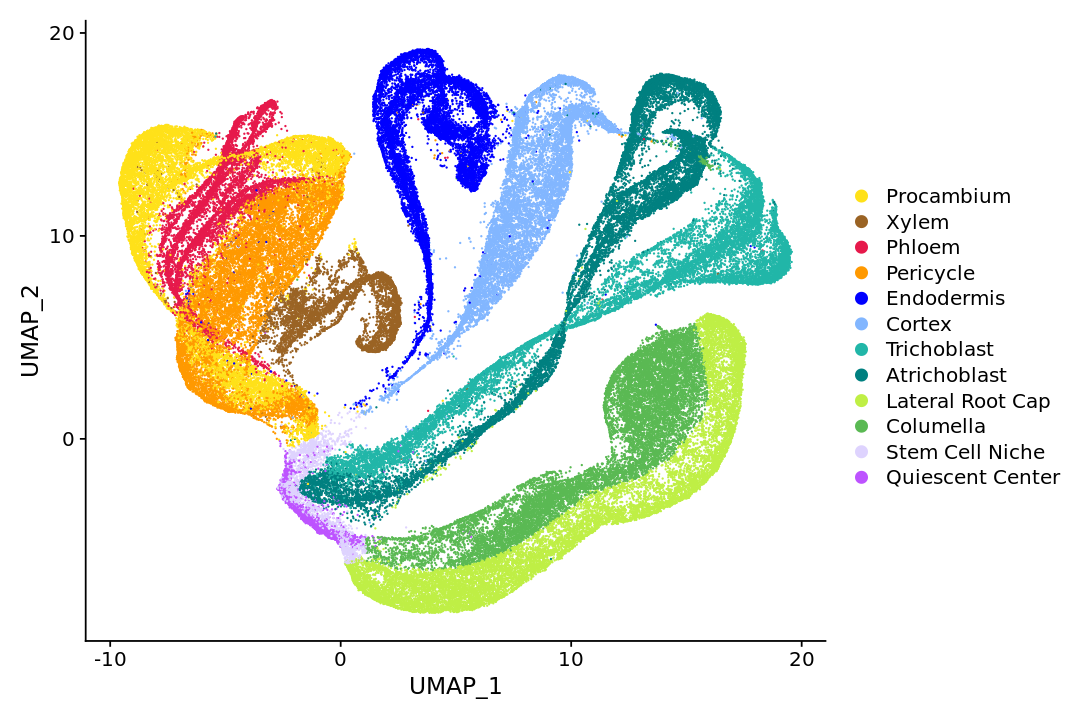

In [73]:
options(repr.plot.width=9, repr.plot.height=6)

order <- c("Quiescent Center", "Stem Cell Niche", "Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Pericycle", "Phloem", "Xylem", "Procambium", "Unknown")
order <- rev(order)
palette <- c("#BD53FF", "#DED3FE", "#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#FF9900","#E6194B", "#9A6324", "#FFE119","#EEEEEE")
palette <- rev(palette)
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))])
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]

cell_dim <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color)

cell_dim[[1]]$layers[[1]]$aes_params$alpha = 1 # can change w/ this if you like. I decided not to so side anno would match 

cell_dim

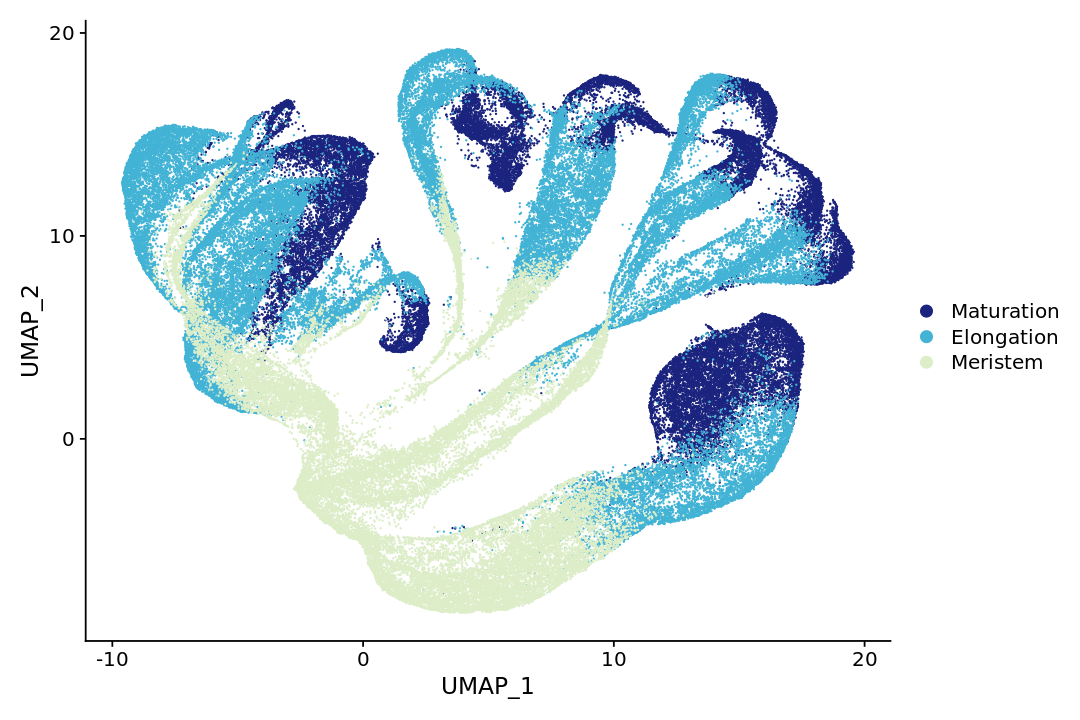

In [74]:
options(repr.plot.width=9, repr.plot.height=6)
time_plt <- DimPlot(rc.integrated, 
        group.by = "time.anno", 
        order = c("Meristem","Elongation","Maturation"),
        cols = c("#1A237E", "#42B3D5", "#DCEDC8"))
time_plt 

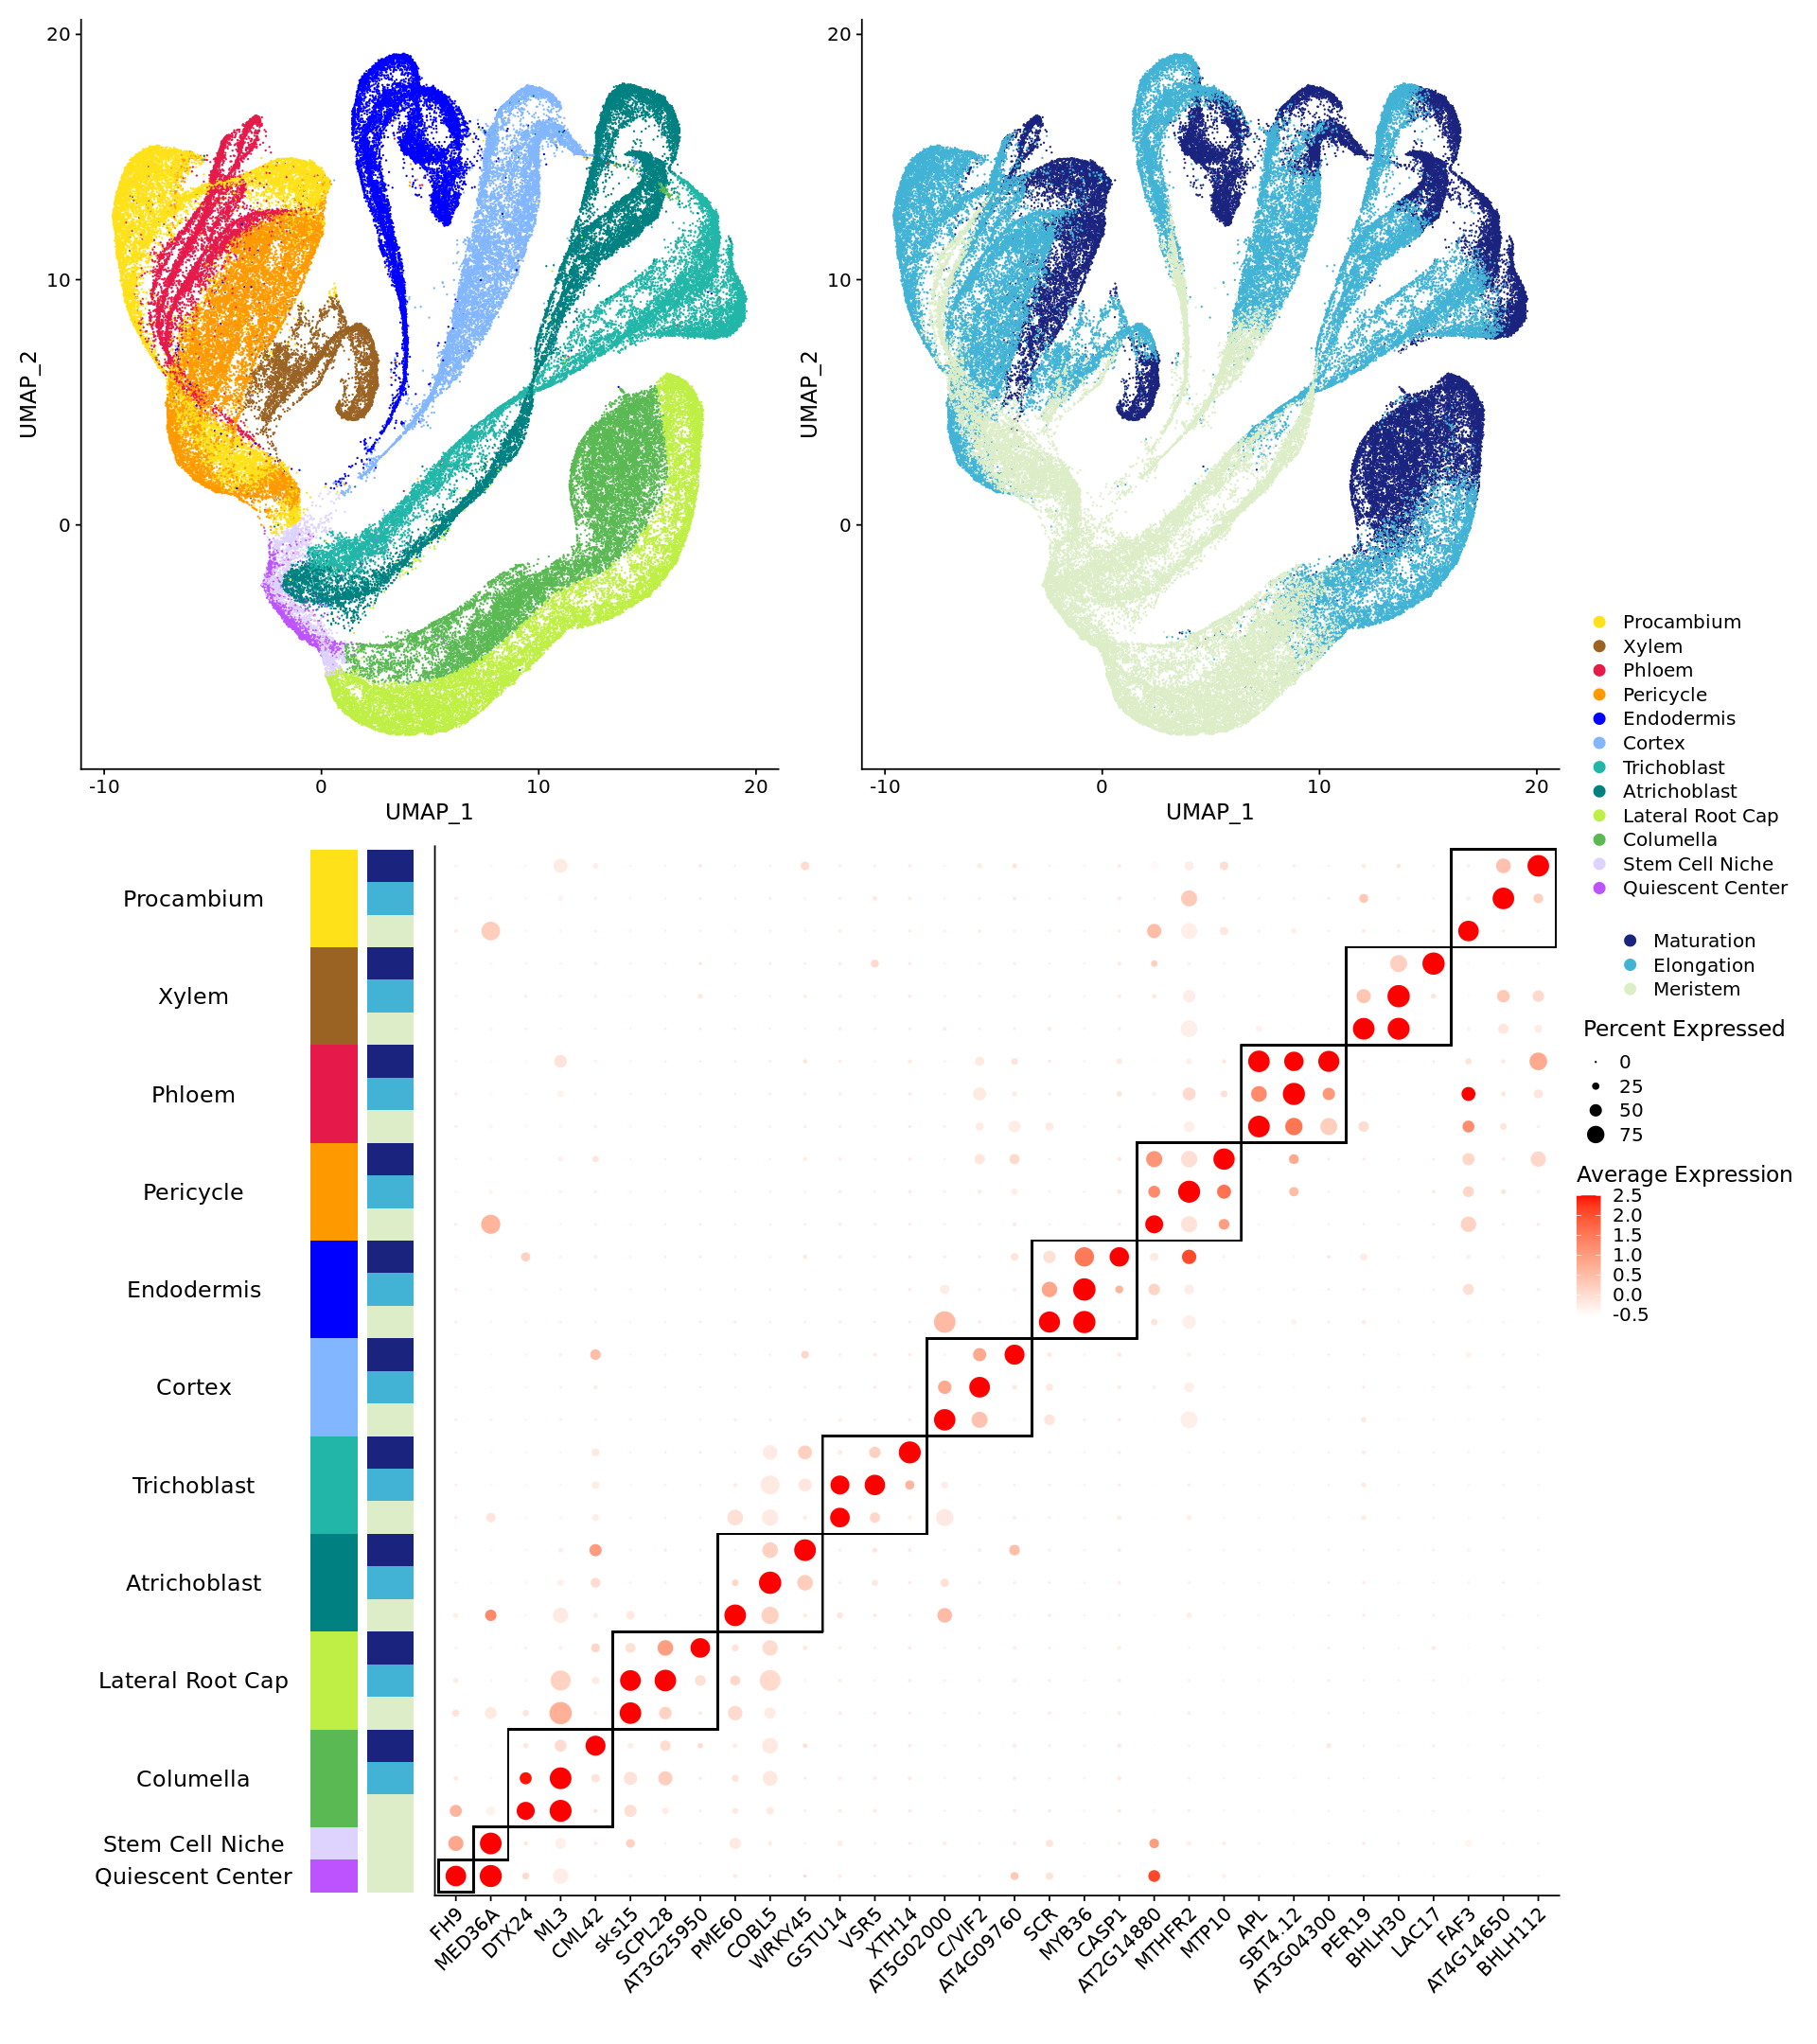

In [75]:
options(repr.plot.width=16, repr.plot.height=18)
(cell_dim + time_plt) / combined_marker_plot + patchwork::plot_layout(nrow=2, heights = c(1, 1.4), guides = 'collect')

In [76]:
ggsave("./supp_data/Atlas_cell_dev_marker_dot.pdf", width=16, height=18)

In [77]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/tmnolan7/anaconda3/envs/r_3.6.1/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.8.2        gprofiler2_0.1.8     GeneOverlap_1.22.0  
 [4] circlize_0.4.8       ComplexHeatmap_2.2.0 cowplot_1.0.0       
 [7] future_1.17.0        RColorBrewer_1.1-2   Seurat_3.1.5        
[10] forcats_0.5.0        stringr_1.4.0        dplyr_0.8.5         
[13] purrr_0